<p>
    <img src = "https://www.novaims.unl.pt/images/logo.png" width = 100>
    <b><font size = 6>Human Resources Analysis - Predicting Attrition</font></b>
</p>
<h2 align=left><font size = 4>EDS Bootcamp project | Enterprise Data Science and Analytics (2019)</font></h2>

*Authors: Bruno Candeias<sup>1</sup>, David Oliveira<sup>2</sup>, Henrique Pereira<sup>3</sup> & Manuel Oom<sup>4</sup>*
1. *M20180313: M20180313@novaims.unl.pt*
2. *M20181430: M20181430@novaims.unl.pt*
3. *M20181395: M20181395@novaims.unl.pt*
4. *M20181431: M20181431@novaims.unl.pt*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.cluster import KMeans, OPTICS
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import os
import tempfile

from auxiliary import grids_skf_lr, grids_skf_lsvc, grids_skf_rf, grids_skf_svc, \
    grids_skf_xgb, plot_cm, plot_elbow_kmeans, plot_nn_metrics, plot_pr_curve, \
    plot_roc, save_metrics

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# Load of pre processed data
%run -i data_pre_proc.py

	2 columns, ['EmployeeCount', 'StandardHours'] were droped
	The ['Over18'] column was droped.
	Pattern " " cleared.
	Pattern "Travel_" cleared.
	Pattern "-" cleared.
	Pattern "&" cleared.
--------------------------------------------------------------------------
 Pre-processing concluded on  ../Data/HR_DS.csv with success.
 Dataframes produced: finaldf
 Other instances created: n_features
 ___________________________________________________________________________


# I. Introduction and Workflow
Our approach to the problem at hand is as follows in the next flowchart or pipeline. This was due, namely, to the fact that: 
1. The dataset is imbalanced;
2. There is no time dimension to the data available;
3. There is no great volume of data

First, the dataset will be split into 2 stratified sets of data so that the following is available:
* A train dataset (features and labels appart) (90%)
    * The models will be trained and validated on this subset;
    * For sake of reproducibility we will apply the same techniques in order to find the best performance model;
    * The best model(s) will be selected to train on this full data subset before being tested against the test dataset (as follows)
* A test dataset (features and labels appart) (10%)
    * This will be used to test the final models as an out-of-sample dataset.
    
After the selection of best model(s) there will be extracted feature importance by permutation and a cluster analysis/profiling.
The resulting insights will be used as an holistic advise on:
* Feature Improvement to avoid atritrion
* Attrition Prediction

In [2]:
from IPython.core.display import display, HTML
display(HTML('../resources/modeling.html'))

# II. Models

## A. Settings and global instances

In [4]:
# test 10%; train 90%
train_df, test_df = train_test_split(finaldf, test_size=0.1, random_state=0, stratify=finaldf.Attrition_Yes)

# Initialization of min-max normalizing scaler
minmax = MinMaxScaler()

# Form np arrays of labels and features
train_labels = np.array(train_df.Attrition_Yes)
test_labels = np.array(test_df.Attrition_Yes)

# The train and test features will be normalized separatedly in order not to cross-contaminate data
train_features = train_df.drop('Attrition_Yes', axis=1)
test_features = minmax.fit_transform(test_df.drop('Attrition_Yes', axis=1))
train_features_norm = minmax.fit_transform(train_features)

# vectorize train features
train_features_v = np.array(train_features)

# initialization of the dataframe to store the metrics for each model evaluated on test split
m_summary = pd.DataFrame(columns=[
    'model','tp', 'fp', 'tn', 'fn', 
    'bal_acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef', 
    'batch_s', 'data', 'series'
])

# standart number of folds to be used by StratifiedKfold sampling
n_folds = 10

print('Training labels shape:', train_labels.shape)
print('Test labels shape:', test_labels.shape)
print('')
print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1323,)
Test labels shape: (147,)

Training features shape: (1323, 41)
Test features shape: (147, 41)


In [5]:
# Instantiate the cross validator
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)

In [6]:
# Original dataset normalized
finaldf_norm = pd.DataFrame(minmax.fit_transform(finaldf), columns=finaldf.columns)

### A.1. Cluster attribution
Before dwelling into the modeling phase, we'll find the clusters in order to better describe the employees with attrition by means of *personas*

Finding the optimal number of kmeans clusters will also be essential to the SMOTE algorithm, so it can nullify the imbalance on the dataset by artificially add more records with attrition equal to 'yes'.

In [7]:
finaldf_norm.Attrition_Yes = finaldf_norm.Attrition_Yes.apply(lambda x: int(x*2))

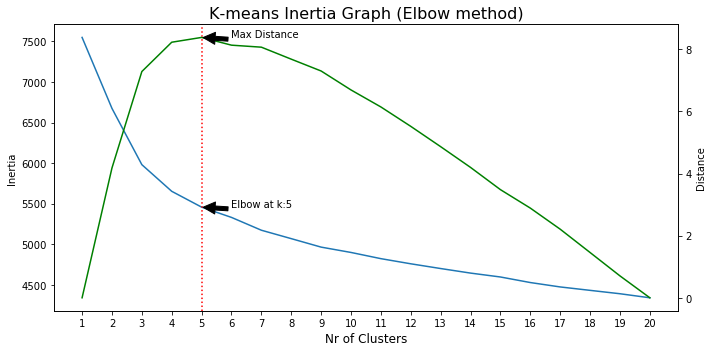

The best number of clusters is 5


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=30, n_jobs=-1, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [8]:
# Optics --> to use in attrition == Yes
optics_model = OPTICS(
    n_jobs=-1
)
optics_model.fit(finaldf_norm)

# Kmeans --> to use in attrition == No
kmeans_model = KMeans(
    n_clusters=plot_elbow_kmeans(finaldf_norm, 20),
    n_jobs=-1,
    n_init=30,
    random_state=123
)
kmeans_model.fit(finaldf_norm)

In [9]:
# dataframe with clusters label
finaldf_clusters = finaldf.copy()
finaldf_clusters['optics_cluster'] = optics_model.labels_
finaldf_clusters['kmeans_cluster'] = kmeans_model.labels_

finaldf_n_clusters = finaldf_norm.copy()
finaldf_n_clusters['optics_cluster'] = optics_model.labels_
finaldf_n_clusters['kmeans_cluster'] = kmeans_model.labels_

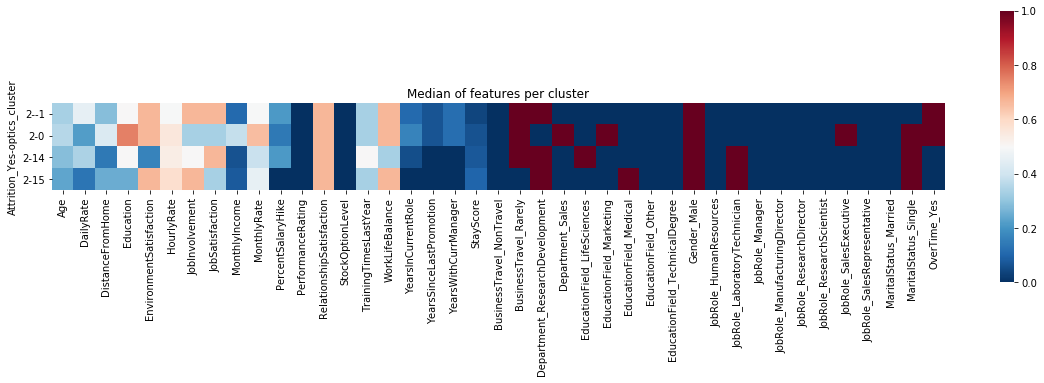

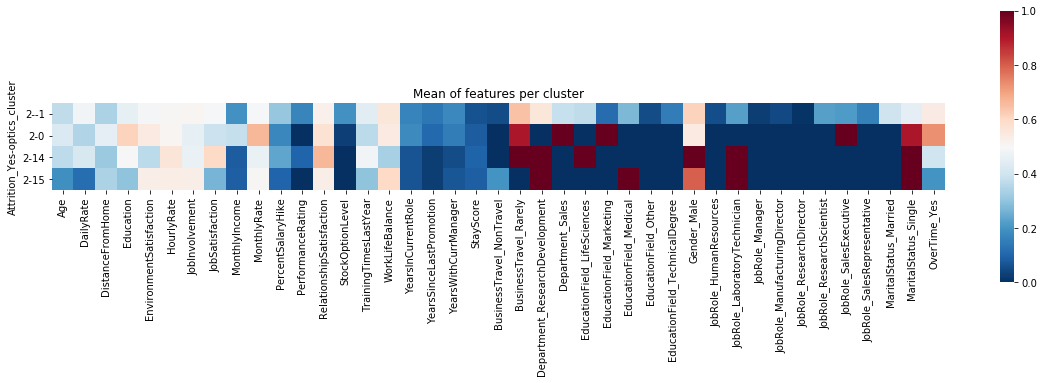

In [12]:
# Characterization of QUITTERS Clusters of the final dataset
plt.figure(figsize=(20,5))
sb.heatmap(
    finaldf_n_clusters[finaldf_n_clusters['Attrition_Yes'] > 0]\
    .drop('kmeans_cluster', axis=1)\
    .groupby(['Attrition_Yes', 'optics_cluster']).median(),
    cmap='RdBu_r',
    square=True,
)
plt.title('Median of features per cluster')
plt.show()
plt.figure(figsize=(20,5))
sb.heatmap(
    finaldf_n_clusters[finaldf_n_clusters['Attrition_Yes'] > 0]\
    .drop('kmeans_cluster', axis=1)\
    .groupby(['Attrition_Yes', 'optics_cluster']).mean(),
    cmap='RdBu_r',
    square=True,
)
plt.title('Mean of features per cluster')
plt.show()

After finding the clusters of the employees with attrition, using the OPTICS algorithm, we can start by seeing the main features for each cluster or *persona*

Ouliers Cluster
	Top features


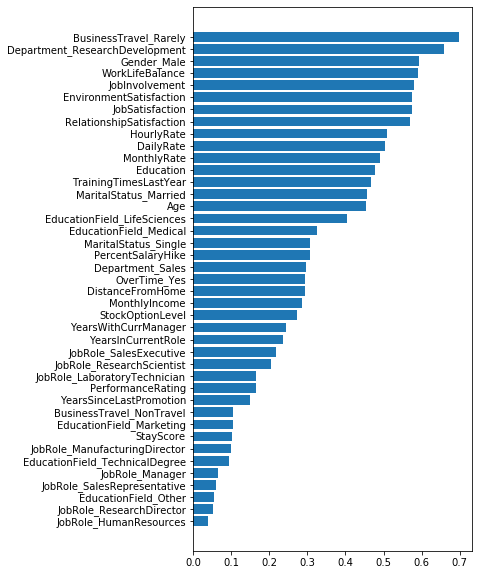

_____________________________________________________
14 Cluster
	Top features


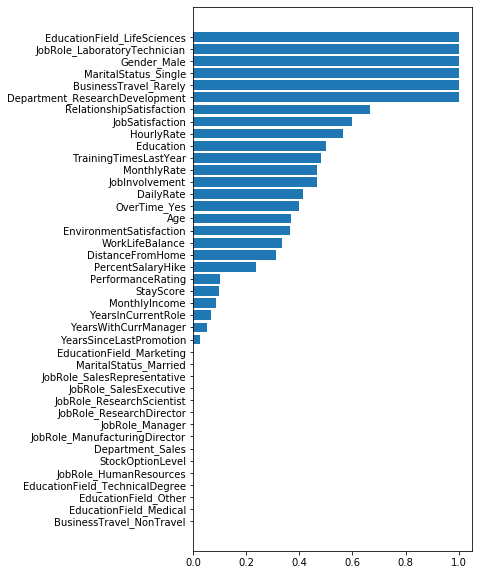

_____________________________________________________
0 Cluster
	Top features


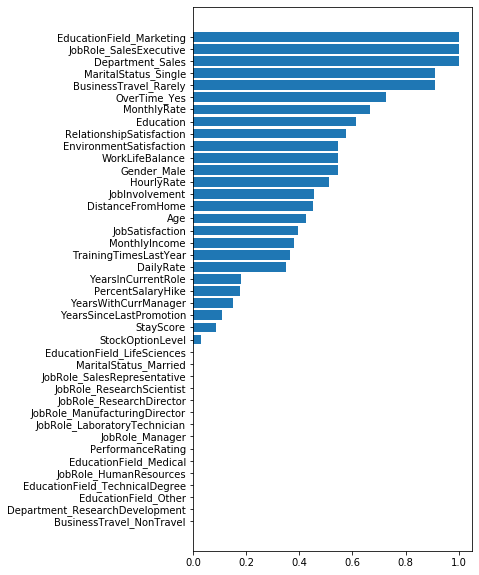

_____________________________________________________
15 Cluster
	Top features


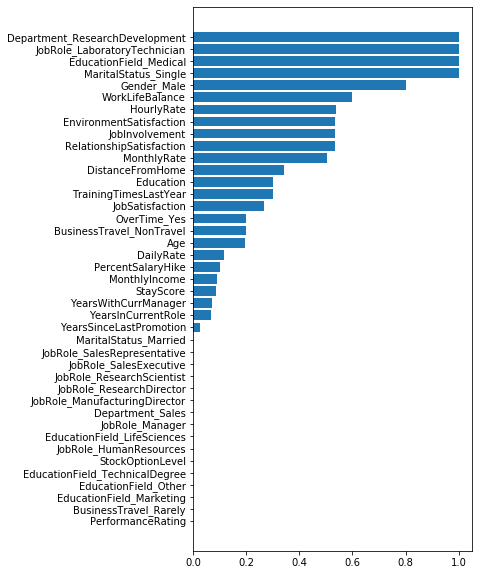

_____________________________________________________


In [13]:
for cluster in finaldf_n_clusters[finaldf_n_clusters['Attrition_Yes'] > 0].optics_cluster.unique():
    if cluster == -1:
        print('Ouliers Cluster')
    else:
        print(str(cluster) + ' Cluster')
    print('\tTop features')
    plt.figure(figsize=(5,10))
    cluster_profile = \
        finaldf_n_clusters[finaldf_n_clusters['optics_cluster'] == cluster]\
        .drop(['kmeans_cluster'], axis=1)\
        .drop(['optics_cluster','Attrition_Yes'], axis=1).mean()\
        .sort_values(ascending=True)
    plt.barh(cluster_profile.index, cluster_profile)
    plt.show()
    print('_____________________________________________________')

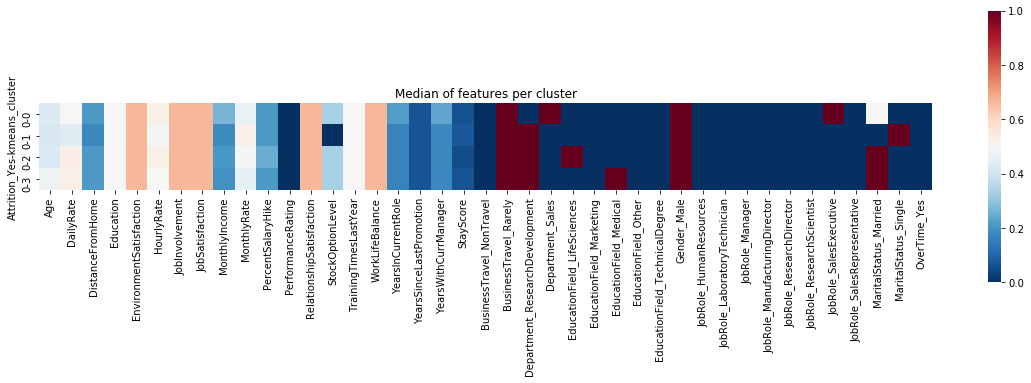

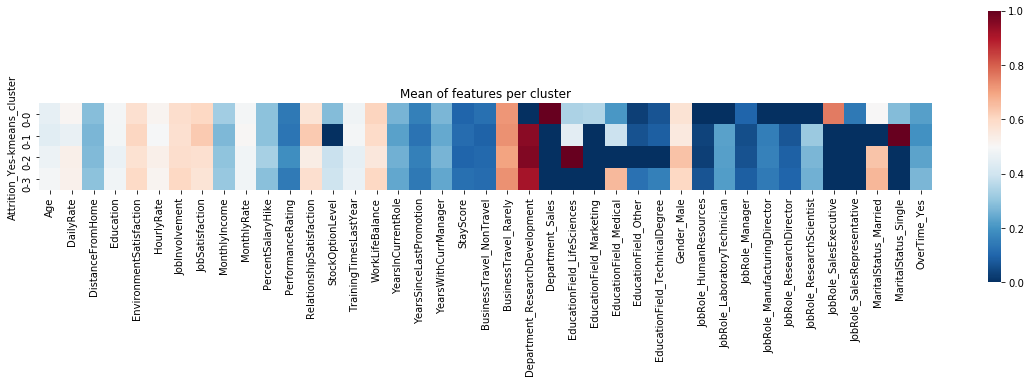

In [14]:
# Characterization of NON quitters Clusters of the final dataset
plt.figure(figsize=(20,5))
sb.heatmap(
    finaldf_n_clusters[finaldf_n_clusters['Attrition_Yes'] < 1]\
        .drop('optics_cluster', axis=1)\
        .groupby(['Attrition_Yes', 'kmeans_cluster']).median(),
    cmap='RdBu_r',
    square=True,
    #annot=True
)
plt.title('Median of features per cluster')
#plt.tight_layout()
plt.show()
plt.figure(figsize=(20,5))
sb.heatmap(
    finaldf_n_clusters[finaldf_n_clusters['Attrition_Yes'] < 1]\
        .drop('optics_cluster', axis=1)\
        .groupby(['Attrition_Yes', 'kmeans_cluster']).mean(),
    cmap='RdBu_r',
    square=True,
    #annot=True
)
plt.title('Mean of features per cluster')
#plt.tight_layout()
plt.show()

2 Cluster
	Top features


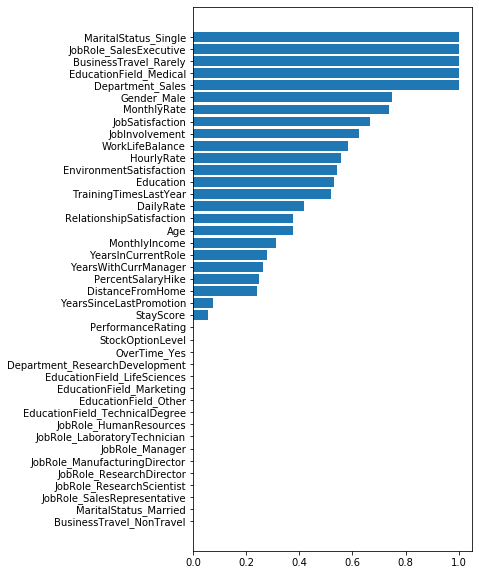

_______________________________________________
3 Cluster
	Top features


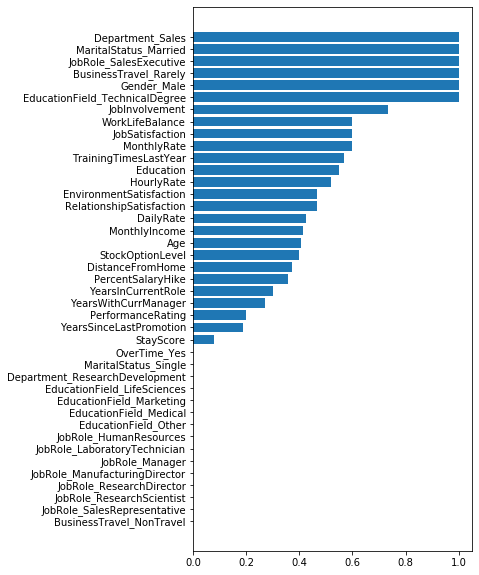

_______________________________________________
1 Cluster
	Top features


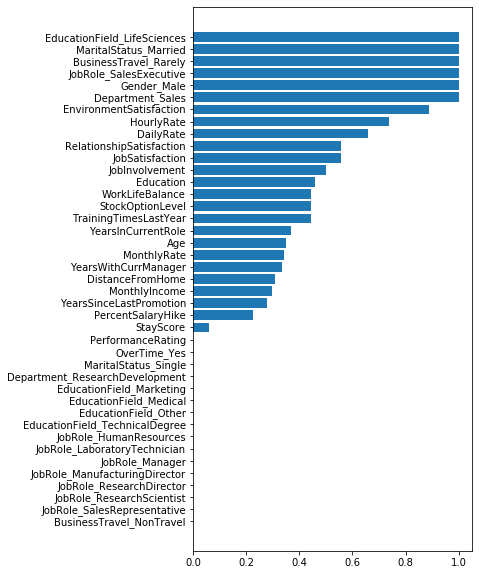

_______________________________________________
0 Cluster
	Top features


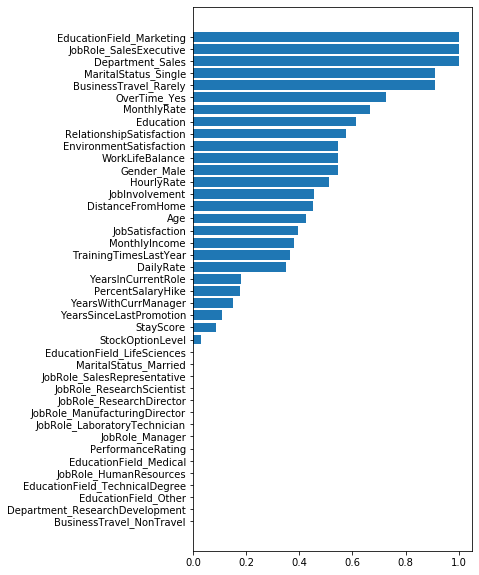

_______________________________________________


In [15]:
for cluster in finaldf_n_clusters[finaldf_n_clusters['Attrition_Yes'] < 1].kmeans_cluster.unique():
    if cluster == -1:
        print('Ouliers Cluster')
    else:
        print(str(cluster) + ' Cluster')
    print('\tTop features')
    plt.figure(figsize=(5,10))
    cluster_profile = finaldf_n_clusters[finaldf_n_clusters['optics_cluster'] == cluster].\
        drop(['optics_cluster','Attrition_Yes', 'kmeans_cluster'], axis=1).mean().\
        sort_values(ascending=True)
    plt.barh(cluster_profile.index, cluster_profile)
    plt.show()
    print('_______________________________________________')

The following dataframe shows the distribuiton of the OPTICS clusters on the original dataset

In [16]:
finaldf_clusters.groupby(['Attrition_Yes','optics_cluster']).count()

Age  DailyRate  DistanceFromHome  Education  \
Attrition_Yes optics_cluster                                                 
0             -1              1148       1148              1148       1148   
               1                 6          6                 6          6   
               2                 8          8                 8          8   
               3                 5          5                 5          5   
               4                 7          7                 7          7   
               5                 7          7                 7          7   
               6                 5          5                 5          5   
               7                 5          5                 5          5   
               8                 9          9                 9          9   
               9                 5          5                 5          5   
               10                5          5                 5          5   
               11                8          8                 8          8   
               12                8          8                 8          8   
               13                7          7                 7          7   
1             -1               211        211               211        211   
               0                11         11                11         11   
               14               10         10                10         10   
               15                5          5                 5          5   

                              EnvironmentSatisfaction  HourlyRate  \
Attrition_Yes optics_cluster                                        
0             -1                                 1148        1148   
               1                                    6           6   
               2                                    8           8   
               3                                    5           5   
               4                                    7           7   
               5                                    7           7   
               6                                    5           5   
               7                                    5           5   
               8                                    9           9   
               9                                    5           5   
               10                                   5           5   
               11                                   8           8   
               12                                   8           8   
               13                                   7           7   
1             -1                                  211         211   
               0                                   11          11   
               14                                  10          10   
               15                                   5           5   

                              JobInvolvement  JobSatisfaction  MonthlyIncome  \
Attrition_Yes optics_cluster                                                   
0             -1                        1148             1148           1148   
               1                           6                6              6   
               2                           8                8              8   
               3                           5                5              5   
               4                           7                7              7   
               5                           7                7              7   
               6                           5                5              5   
               7                           5                5              5   
               8                           9                9              9   
               9                           5                5              5   
               10                          5                5              5   
               11                          8     

### A.2. Imbalanced Series (original weights)
A check on the imbalance of the datasets is needed as follows:

In [17]:
neg_df, pos_df = np.bincount(finaldf.Attrition_Yes)
total_df = neg_df + pos_df
neg_test, pos_test = np.bincount(test_labels)
total_test = neg_test + pos_test
neg_t, pos_t = np.bincount(train_labels)
total_t = neg_t + pos_t

print('Cases on full dataset:\n\tTotal: {}\n\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_df, pos_df, 100 * pos_df / total_df))
print('\tCases on test dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_test, pos_test, 100 * pos_test / total_test))
print('\tCases on training dataset:\n\t\tTotal: {}\n\t\tEmployees that Left the company: {} ({:.2f}% of total)\n'.format(
    total_t, pos_t, 100 * pos_t / total_t))

Cases on full dataset:
	Total: 1470
	Employees that Left the company: 237 (16.12% of total)

	Cases on test dataset:
		Total: 147
		Employees that Left the company: 24 (16.33% of total)

	Cases on training dataset:
		Total: 1323
		Employees that Left the company: 213 (16.10% of total)



A determination of the weights of the target label (train dataset) will be important further on the testing of the models

In [18]:
# Scaling by total/2(categories) helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg_t)*(total_t)/2
weight_for_1 = (1 / pos_t)*(total_t)/2

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0 (Stayers): {:.2f}'.format(weight_for_0))
print('Weight for class 1 (Leavers): {:.2f}'.format(weight_for_1))

Weight for class 0 (Stayers): 0.60
Weight for class 1 (Leavers): 3.11


### A.3. Oversampled Series (SMOTE)
In order to minimize impact of the imbalance on the original dataset, We'll be using SMOTE to generate artificial data based on the k nearest neighbours of the train data subset.

In [19]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


Creation of A new Dataframe from the Train_df but assigning extra weight to the label Attrition to better compute optimal clusters knowing that an Employee that exist the company is from a different cluster than the other, assuming that there are common features shared in this group. 

In [20]:
traindf_norm = pd.DataFrame(minmax.fit_transform(train_df), columns=train_df.columns)
traindf_norm.Attrition_Yes = traindf_norm.Attrition_Yes*2

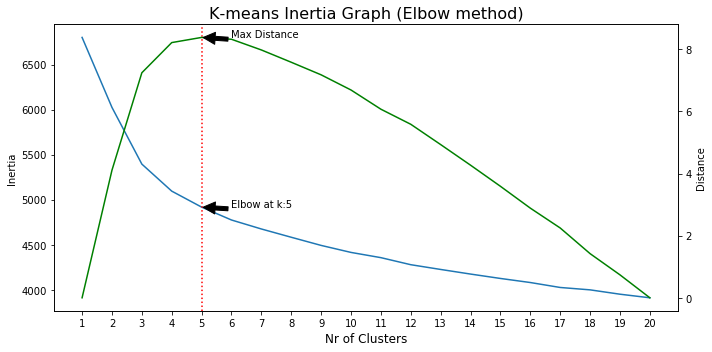

The best number of clusters is 5


In [21]:
# Plotting the kmeans range to find optimal k nearest neighbourgs --> to be used in SMOTE algorithm
n_kn = plot_elbow_kmeans(traindf_norm, 20)

In [22]:
smote = SMOTE(
    k_neighbors=n_kn,
    random_state=0,
    n_jobs=-1
)

In [23]:
# producing the data subset oversampled
X_SMOTE, y_SMOTE = smote.fit_sample(train_features, train_labels)

X_SMOTE_mm = minmax.fit_transform(X_SMOTE)

This data subset will have equal weights for both classes of the target labels. In this case the artificial data produced belong to class '1', the employees who have left the company (Attrition = Yes)

## 1. XGBoost

### 1.1. Imbalanced Series

#### 1.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [24]:
# fit model on training data
parameters_XGB = {
    'objective':['binary:logistic'],
    'learning_rate': [0.1, 0.05],
    'max_depth': [i for i in range(3,5)],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5, 1],
    'n_estimators': [500, 1000],
    'seed': [123]}

model_XGB = grids_skf_xgb(
    train_features,
    train_labels, 
    parameters_XGB, 
    pos_t/neg_t, 
    n_folds
)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:   58.5s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.1918918918918919,
              seed=123, silent=None, subsample=0.5, verbosity=0)


#### 1.1.2. Evaluation - Stratified K-Fold CV

In [25]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_XGB.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_XGB', ytrain, model_XGB.predict(xtrain), model_XGB.predict_proba(xtrain)[:, 1], 
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_XGB', yval, model_XGB.predict(xval), model_XGB.predict_proba(xval)[:, 1], 
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_XGB', test_labels, model_XGB.predict(test_features), model_XGB.predict_proba(test_features)[:, 1], 
        split_data='test', series='imbalanced')
print(' ...Done')

 ...Done on fold 10/10...


### 1.2. Oversampling Series

#### 1.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [26]:
# fit model on training data
model_XGB_smote = grids_skf_xgb(
    X_SMOTE,
    y_SMOTE, 
    parameters_XGB,
    1,
    n_folds
)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  1.6min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=0.5, verbosity=0)


#### 1.2.2. Evaluation - Stratified K-Fold CV

In [27]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    
    # train model
    model_XGB_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_XGB', ytrain_SMOTE, model_XGB_smote.predict(xtrain_SMOTE), model_XGB_smote.predict_proba(xtrain_SMOTE)[:, 1], 
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_XGB', yval, model_XGB_smote.predict(xval), model_XGB_smote.predict_proba(xval)[:, 1],
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_XGB', test_labels, model_XGB_smote.predict(test_features), model_XGB_smote.predict_proba(test_features)[:, 1], 
        split_data='test', series='SMOTE')
print(' ...Done')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 ...Done on fold 10/10...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


## 2. Logistic Regression

### 2.1. Imbalanced Series

#### 2.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [28]:
parameters_log = [{
    'solver' : ['sag'],
    'C' : [1, 10, 100],
    'max_iter': [10000],
    'penalty' : ('none', 'l2'),
    'warm_start' : (True, False),
    'fit_intercept' : [True, False]
},{
    'solver' : ['liblinear', 'saga'], 
    'C' : [1, 10, 100],
    'max_iter': [10000],
    'penalty' : ('l1', 'l2'),
    'warm_start' : (True, False),
    'fit_intercept' : [True, False]
}]

model_logistic = grids_skf_lr(
    train_features,
    train_labels, 
    parameters_log, 
    class_weights, 
    n_folds
)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:   24.0s


LogisticRegression(C=1,
                   class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=10000, multi_class='ovr', n_jobs=-1,
                   penalty='l2', random_state=0, solver='sag', tol=0.0001,
                   verbose=0, warm_start=True)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   26.9s finished


#### 2.1.2. Evaluation - Stratified K-Fold CV

In [29]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_logistic.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_logistic', ytrain, model_logistic.predict(xtrain), model_logistic.predict_proba(xtrain)[:, 1],
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_logistic', yval, model_logistic.predict(xval), model_logistic.predict_proba(xval)[:, 1],
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_logistic', test_labels, model_logistic.predict(test_features), model_logistic.predict_proba(test_features)[:, 1],
        split_data='test', series='imbalanced')
print(' ...Done')

 ...Done on fold 10/10...


### 2.2. Oversampling Series

#### 2.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [30]:
model_logistic_smote = grids_skf_lr(
    X_SMOTE,
    y_SMOTE, 
    parameters_log,
    {0: 1, 1: 1},
    n_folds
)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 514 tasks      | elapsed:   26.5s


LogisticRegression(C=10, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=-1, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=True)


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   38.8s finished


#### 2.2.2. Evaluation - Stratified K-Fold CV

In [31]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)
    
    # train model
    model_logistic_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_logistic', ytrain_SMOTE, model_logistic.predict(xtrain_SMOTE), model_logistic.predict_proba(xtrain_SMOTE)[:, 1],
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_logistic', yval, model_logistic.predict(xval), model_logistic.predict_proba(xval)[:, 1],
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_logistic', test_labels, model_logistic.predict(test_features), model_logistic.predict_proba(test_features)[:, 1],
        split_data='test', series='SMOTE')
print(' ...Done')

 ...Done on fold 10/10...


## 3. LinearSVC

### 3.1. Imbalanced Series

#### 3.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [32]:
parameters_lsvc = [{
    'C' : [i for i in range(1,10,2)],
    'penalty' : ['l1', 'l2'],
    'max_iter': [10000, 100000, 1000000]
}]

model_LinearSVC = grids_skf_lsvc(
    train_features, 
    train_labels, 
    parameters_lsvc, 
    class_weights, 
    n_folds
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.3s


LinearSVC(C=3, class_weight={0: 0.595945945945946, 1: 3.1056338028169015},
          dual=False, fit_intercept=True, intercept_scaling=1,
          loss='squared_hinge', max_iter=10000, multi_class='ovr', penalty='l2',
          random_state=0, tol=0.0001, verbose=0)


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.7s finished


#### 3.1.2. Evaluation - Stratified K-Fold CV

In [33]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_LinearSVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', ytrain, model_LinearSVC.predict(xtrain), model_LinearSVC.decision_function(xtrain),
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', yval, model_LinearSVC.predict(xval), model_LinearSVC.decision_function(xval),
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', test_labels, model_LinearSVC.predict(test_features), model_LinearSVC.decision_function(test_features),
        split_data='test', series='imbalanced')
print(' ...Done')

 ...Done on fold 10/10...


### 3.2. Oversampling Series

#### 3.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [34]:
model_LinearSVC_smote = grids_skf_lsvc(
    X_SMOTE, 
    y_SMOTE, 
    parameters_lsvc,
    {0: 1, 1: 1},
    n_folds
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.3s finished


LinearSVC(C=1, class_weight={0: 1, 1: 1}, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l1', random_state=0, tol=0.0001,
          verbose=0)


#### 3.2.2. Evaluation - Stratified K-Fold CV

In [35]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)
    
    # train model
    model_LinearSVC_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', ytrain_SMOTE, model_LinearSVC_smote.predict(xtrain_SMOTE), model_LinearSVC_smote.decision_function(xtrain_SMOTE),
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', yval, model_LinearSVC_smote.predict(xval), model_LinearSVC_smote.decision_function(xval),
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_LinearSVC', test_labels, model_LinearSVC_smote.predict(test_features), model_LinearSVC_smote.decision_function(test_features),
        split_data='test', series='SMOTE')
print(' ...Done')

 ...Done on fold 10/10...


## 4. SVC

### 4.1. Imbalanced Series

#### 4.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [36]:
parameters_svc = [{
    'kernel' : ['rbf', 'linear', 'poly', 'sigmoid'],
    'C' : [i for i in range(1,10,2)],
    'gamma' : [1, 0.1],
    'coef0' : [1, 0.1],
    'shrinking' : [True, False]
}]

model_SVC = grids_skf_svc(
    train_features,
    train_labels,
    parameters_svc,
    class_weights,
    n_folds
)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.5min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1, cache_size=200,
    class_weight={0: 0.595945945945946, 1: 3.1056338028169015}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


#### 4.1.2. Evaluation - Stratified K-Fold CV

In [37]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_SVC.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_SVC', ytrain, model_SVC.predict(xtrain), model_SVC.predict_proba(xtrain)[:, 1],
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_SVC', yval, model_SVC.predict(xval), model_SVC.predict_proba(xval)[:, 1],
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_SVC', test_labels, model_SVC.predict(test_features), model_SVC.predict_proba(test_features)[:, 1],
        split_data='test', series='imbalanced')
print(' ...Done')

 ...Done on fold 10/10...


### 4.2. Oversampling Series

#### 4.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [38]:
model_SVC_smote = grids_skf_svc(
    X_SMOTE,
    y_SMOTE,
    parameters_svc,
    {0: 1, 1: 1},
    n_folds
)

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  3.7min finished


SVC(C=3, cache_size=200, class_weight={0: 1, 1: 1}, coef0=1,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
    max_iter=5000, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


#### 4.2.2. Evaluation - Stratified K-Fold CV

In [39]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)

    # train model
    model_SVC_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_SVC', ytrain_SMOTE, model_SVC_smote.predict(xtrain_SMOTE), model_SVC_smote.predict_proba(xtrain_SMOTE)[:, 1],
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_SVC', yval, model_SVC_smote.predict(xval), model_SVC_smote.predict_proba(xval)[:, 1],
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_SVC', test_labels, model_SVC_smote.predict(test_features), model_SVC_smote.predict_proba(test_features)[:, 1],
        split_data='test', series='SMOTE')
print(' ...Done')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 ...Done on fold 10/10...


## 5. Random Forest Classifier

### 5.1. Imbalanced Series

#### 5.1.1. Optimization - GridSearch & Stratified K-Fold CV

In [40]:
parameters_rf = [{
    'n_estimators' : [100, 500, 1000],
    'max_depth' : [i for i in range(3,15,3)],
    'min_samples_split' : [i for i in range (2,4)],
    'min_samples_leaf' : [i for i in range (2,4)]
}]

model_RandomForest = grids_skf_rf(
    train_features, 
    train_labels, 
    parameters_rf, 
    class_weights, 
    n_folds
)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.7min finished


RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.595945945945946,
                                     1: 3.1056338028169015},
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=3,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)


#### 5.1.2. Evaluation - Stratified K-Fold CV

In [41]:
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_norm[train_indices], train_features_norm[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # train model
    model_RandomForest.fit(xtrain, ytrain)
    
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', ytrain, model_RandomForest.predict(xtrain), model_RandomForest.predict_proba(xtrain)[:, 1],
        split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', yval, model_RandomForest.predict(xval), model_RandomForest.predict_proba(xval)[:, 1],
        split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', test_labels, model_RandomForest.predict(test_features), model_RandomForest.predict_proba(test_features)[:, 1],
        split_data='test', series='imbalanced')
print(' ...Done')

 ...Done on fold 10/10...


### 5.2. Oversampling Series

#### 5.2.1. Optimization - GridSearch & Stratified K-Fold CV

In [42]:
model_RandomForest_smote = grids_skf_rf(
    X_SMOTE, 
    y_SMOTE, 
    parameters_rf, 
    {0: 1, 1: 1}, 
    n_folds
)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.2min finished


RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 1},
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)


#### 5.2.2. Evaluation - Stratified K-Fold CV

In [43]:
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)
    
    # train model
    model_RandomForest_smote.fit(xtrain_SMOTE, ytrain_SMOTE)
    
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', ytrain_SMOTE, model_RandomForest_smote.predict(xtrain_SMOTE), model_RandomForest_smote.predict_proba(xtrain_SMOTE)[:, 1],
        split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', yval, model_RandomForest_smote.predict(xval), model_RandomForest_smote.predict_proba(xval)[:, 1],
        split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'model_RandomForest', test_labels, model_RandomForest_smote.predict(test_features), model_RandomForest_smote.predict_proba(test_features)[:, 1],
        split_data='test', series='SMOTE')
print(' ...Done')

 ...Done on fold 10/10...


## 6. Keras Tensorflow Classification Deep Neural Network

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [45]:
# number of iterations for optimizing
n_opt = 30

In [46]:
#metrics to obtain in history
METRICS = [
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.BinaryAccuracy(name='bin_acc'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
]

# max number of epochs (the early stopping callback will cutoff before)
EPOCHS = 300 
#best batch size = 64, 70, 32, 128, 256
BATCH_SIZE = 32

# Defining specific callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=0,
    patience=20, #best 20
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=5,
    cooldown=6,
    min_lr=0.00001
)

callback = [
    early_stopping,
    reduce_lr
]

if n_features%2 == 0:
    n_init_neurons = n_features
else:
    n_init_neurons = n_features+1
    
print('The advisable number of neurons in the first layer should be: ', n_init_neurons)

The advisable number of neurons in the first layer should be:  42


Constructor of Keras model definition

In [47]:
def make_model(
    metrics = METRICS,
    output_bias = None, 
    learn_rate = 0.001, 
    l1_neurons = n_init_neurons, 
    l2_neurons = 24, 
    input_shape = train_features.shape[-1:], 
    l2_dropout = 0.25
):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = Sequential(
        [
            #First hidden layer
        Dense(
            l1_neurons, 
            activation=keras.layers.ELU(), 
            input_shape=input_shape,
            name='first_hidden_layer'
        ),
            #Normalization layer
        BatchNormalization(name='first_Batch_norm'),
            #Second hidden layer
        Dense(
            l2_neurons,
            activation=keras.layers.LeakyReLU(),
            name='second_hidden_layer'
        ),
            #Normalization layer
        BatchNormalization(name='second_Batch_norm'),
            #Dropout layer
        Dropout(
            l2_dropout,
            name='l2_dropout_layer'
        ),
            #Output layer
        Dense(
            1, 
            activation='sigmoid',                   # sigmoid for regressor with probability output
            bias_initializer=output_bias,
            name='output_layer'
        )
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(lr=learn_rate),
            #Optimizer to use
            #optimizer_ = keras.optimizers.Adam(lr=learn_rate)
            #optimizer=keras.optimizers.Nadam(lr=learn_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

In [48]:
make_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_hidden_layer (Dense)   (None, 42)                1764      
_________________________________________________________________
first_Batch_norm (BatchNorma (None, 42)                168       
_________________________________________________________________
second_hidden_layer (Dense)  (None, 24)                1032      
_________________________________________________________________
second_Batch_norm (BatchNorm (None, 24)                96        
_________________________________________________________________
l2_dropout_layer (Dropout)   (None, 24)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 25        
Total params: 3,085
Trainable params: 2,953
Non-trainable params: 132
____________________________________________________

### 6.1. Imbalanced Series

#### 6.1.1. Optimization - Bayesian Optimization on weighted model

Bayesian Optimization on the train dataset to better tune hyperparameters on the model.

Defining black box function

In [50]:
def fit_with(
    learn_rate, 
    l1_neurons, 
    l2_neurons, 
    l2_dropout,
    BATCH_SIZE,
    X = train_features,
    y = train_labels
):
    X = np.array(train_features)
    y = train_labels
    # Split of data for evaluation (random state defined)
    X, X_val, y, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.1)
    # Instatiate model
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    # Discretize parameters
    l1_neurons = max(int(l1_neurons)*2, 32)
    l2_neurons = max(int(l2_neurons)*2, 2)
    BATCH_SIZE = max(int(BATCH_SIZE)*16, 16)
    
    model_keras_opt = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = 0.001,
        l1_neurons = n_init_neurons,
        l2_neurons = 24,
        input_shape = X.shape[-1:],
        l2_dropout = 0.25
    )
    
    results = model_keras_opt.evaluate(minmax.fit_transform(X_val), y_val, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_opt.save_weights(initial_weights)
    
    # Trainning of the model on the training features
    model_keras_opt.fit(
        minmax.fit_transform(X),
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = callback,
        validation_data=(minmax.fit_transform(X_val), y_val),
        class_weight=class_weights,
        verbose=0,
    )
    
    # Evaluation of model with validation data
    scores = model_keras_opt.evaluate(
        x=X_val, 
        y=y_val,
        verbose=0
    )
        
    precision = scores[1]
    recall = scores[2]
    tn = scores[5]
    tp = scores[6]
    fn = scores[7]
    fp = scores[8]
    mc_numerator = (tp * tn + fp * fn)
    mc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-7
    mc_coef = mc_numerator / mc_denominator
    f1_ = 2 * (precision * recall) / (precision + recall + 1e-7) 
    # The target score to maximize
    return f1_

In [51]:
from functools import partial
fit_with_partial = partial(fit_with)

In [52]:
from bayes_opt import BayesianOptimization

In [53]:
p_bounds = {
    'learn_rate':(1e-4, 1e-1), 
    'l1_neurons':(16, 25), # max(int(i)*2, 32) --> 32 to 54
    'l2_neurons':(1, 13), # max(int(i)*2, 2) --> 2 to 24
    'l2_dropout':(0, 0.6),
    'BATCH_SIZE':(1, 4.9), # max(int(i)*16, 16) --> 16 to 64
}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=p_bounds,
    verbose=2,
    random_state=0
)

optimizer.probe(
    params={
    'learn_rate':0.03643, 
    'l1_neurons':21,
    'l2_neurons':4.785,
    'l2_dropout':0.07736,
    'BATCH_SIZE':3.615,
    },
    lazy=True
)

optimizer.maximize(
    init_points=20,
    n_iter=n_opt
)

print('learn_rate:', optimizer.max['params']['learn_rate'])
print('l1_neurons:', max(int(optimizer.max['params']['l1_neurons'])*2, 32))
print('l2_neurons:', max(int(optimizer.max['params']['l2_neurons'])*2, 2))
print('l2_dropout:', optimizer.max['params']['l2_dropout'])
print('BATCH_SIZE:', max(int(optimizer.max['params']['BATCH_SIZE'])*16, 16))

|   iter    |  target   | BATCH_... | l1_neu... | l2_dro... | l2_neu... | learn_... |
-------------------------------------------------------------------------------------
|  1        |  0.3231   |  16.0     |  21.0     |  0.01     |  10.0     |  0.0006   |
|  2        |  0.2016   |  3.14     |  22.44    |  0.3617   |  7.539    |  0.04242  |
|  3        |  0.0      |  3.519    |  19.94    |  0.5351   |  12.56    |  0.03841  |
|  4        |  0.3014   |  4.088    |  20.76    |  0.3408   |  12.11    |  0.007197 |
|  5        |  0.0      |  1.34     |  16.18    |  0.4996   |  10.34    |  0.08701  |
|  6        |  0.0      |  4.817    |  23.19    |  0.2769   |  10.37    |  0.01192  |
|  7        |  0.2727   |  3.496    |  17.29    |  0.5668   |  7.262    |  0.04152  |
|  8        |  0.2727   |  2.032    |  22.97    |  0.2737   |  7.821    |  0.001977 |
|  9        |  0.2727   |  3.409    |  21.51    |  0.3702   |  12.32    |  0.06821  |
|  10       |  0.2727   |  2.402    |  19.93    |  0.4

The best models trained go arrount the following hyperparameters:

First best:

    learn_rate: 0.0005690780716354519
    l1_neurons: 46
    l2_neurons: 20
    l2_dropout: 0.012064527712496132
    BATCH_SIZE: 32
    
Second best:

    learn_rate: 0.011960899123528981
    l1_neurons: 36
    l2_neurons: 8
    l2_dropout: 0.07211793672790134
    BATCH_SIZE: 16

In [54]:
#Saving logs for the best hyperparameters
import datetime
timestamp = datetime.datetime.today().strftime ('%Y%m%d_%H%M')

with open('../logs/nn_opt_log.txt', 'a') as file:
    file.write(str(timestamp) + ','+ 'imbalanced: f1:' + str(optimizer.max) + '\n')
file.close()

In [55]:
learn_rate = optimizer.max['params']['learn_rate']
l1_neurons = max(int(optimizer.max['params']['l1_neurons'])*2, 32)
l2_neurons = max(int(optimizer.max['params']['l2_neurons'])*2, 2)
l2_dropout = optimizer.max['params']['l2_dropout']
BATCH_SIZE = max(int(optimizer.max['params']['BATCH_SIZE'])*16, 16)

tf.keras.backend.clear_session()

We'll select the best hyperparameters as follows:

In [61]:
learn_rate = 0.0005690780716354519
l1_neurons = 46
l2_neurons = 20
l2_dropout = 0.012064527712496132
BATCH_SIZE = 32

#### 6.1.2. Evaluation - Stratified K-Fold CV

In [56]:
model_keras_w_history = []
# Loop through the indices the split() method returns
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_norm, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    
    # Generate batches from indices
    X, X_val = train_features_norm[train_indices], train_features_norm[val_indices]
    y, y_val = train_labels[train_indices], train_labels[val_indices]
    
    # Clear model
    model_keras_w = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    model_keras_w = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = learn_rate,
        l1_neurons = l1_neurons,
        l2_neurons = l2_neurons,
        input_shape = X.shape[-1:],
        l2_dropout = l2_dropout
    )
    
    results = model_keras_w.evaluate(xtrain, ytrain, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_w.save_weights(initial_weights)

    baseline_history = model_keras_w.fit(
        X,
        y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks = callback,
        validation_data=(X_val, y_val),
        class_weight=class_weights,
        verbose=0)
    
    model_keras_w_history.append(baseline_history)
    m_summary = save_metrics(
        m_summary, 'NN_weighted', ytrain, model_keras_w.predict_classes(xtrain), model_keras_w.predict_proba(xtrain),
        batch_size=BATCH_SIZE, split_data='train', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'NN_weighted', yval, model_keras_w.predict_classes(xval), model_keras_w.predict_proba(xval),
        batch_size=BATCH_SIZE, split_data='val', series='imbalanced')
    m_summary = save_metrics(
        m_summary, 'NN_weighted', test_labels, model_keras_w.predict_classes(test_features), model_keras_w.predict_proba(test_features),
        batch_size=BATCH_SIZE, split_data='test', series='imbalanced')
print(' ...Done')

tf.keras.backend.clear_session()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


 ...Done on fold 10/10...


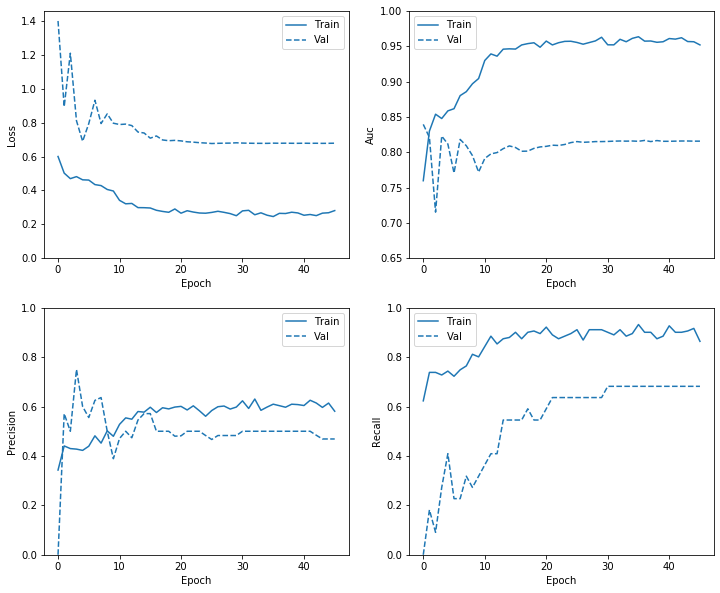

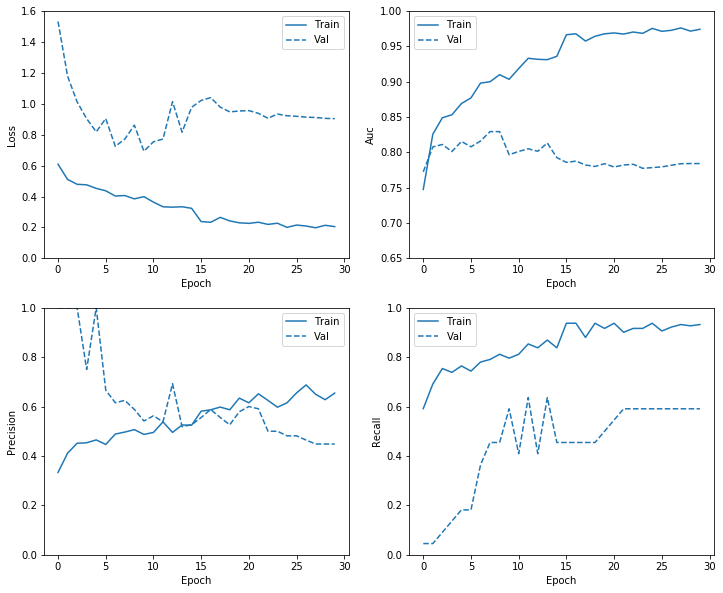

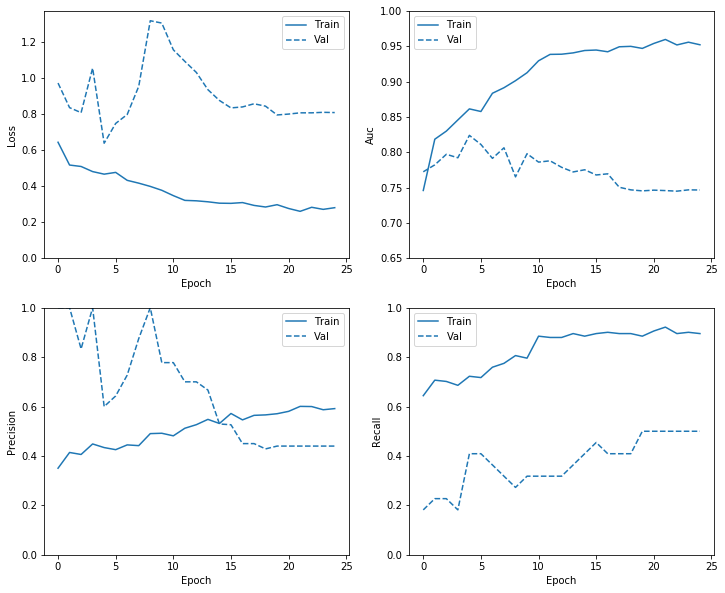

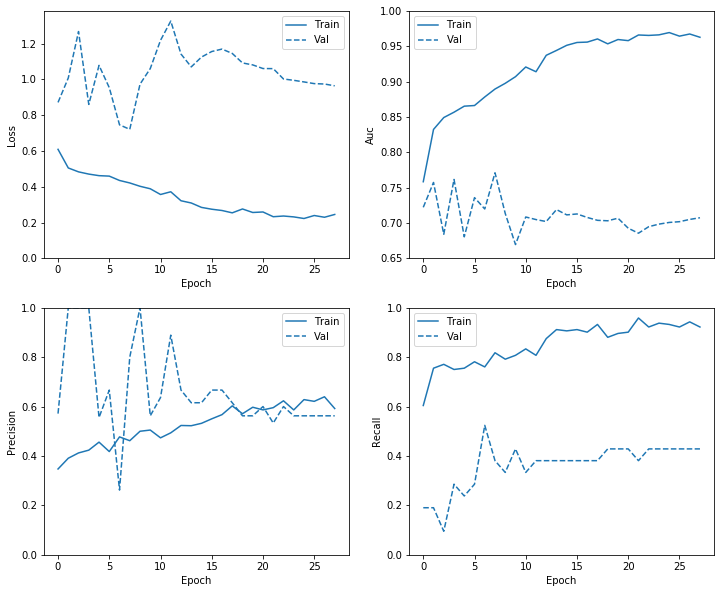

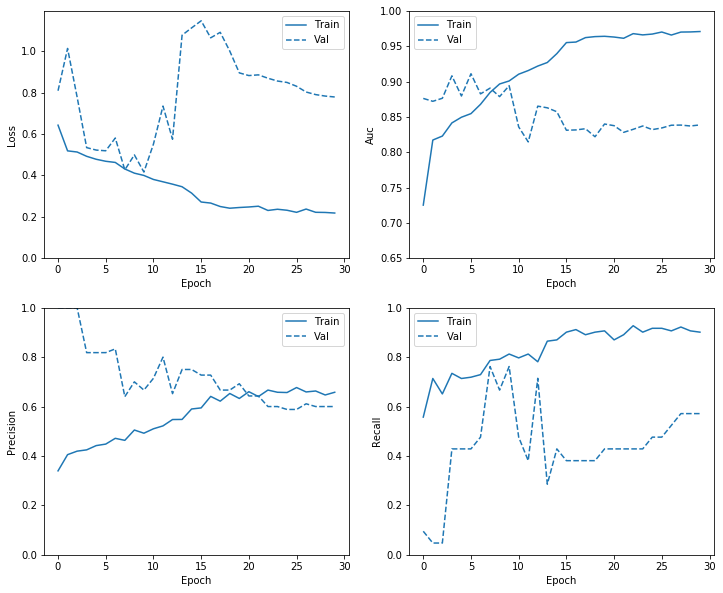

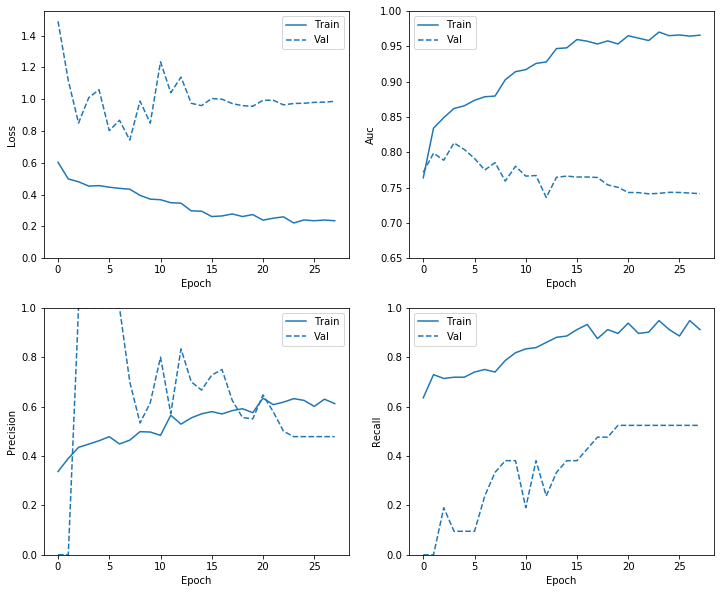

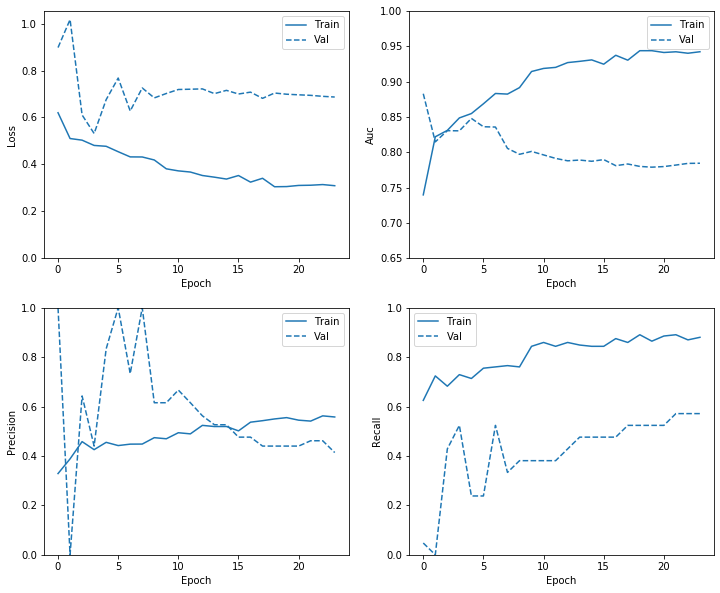

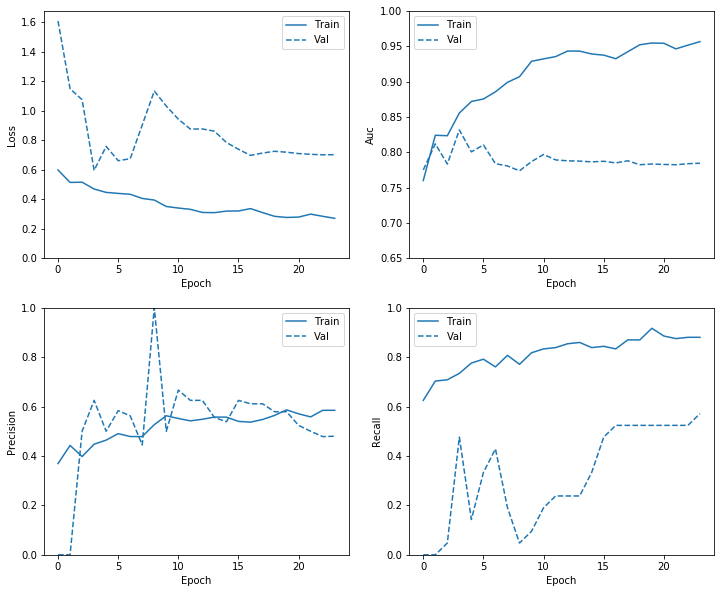

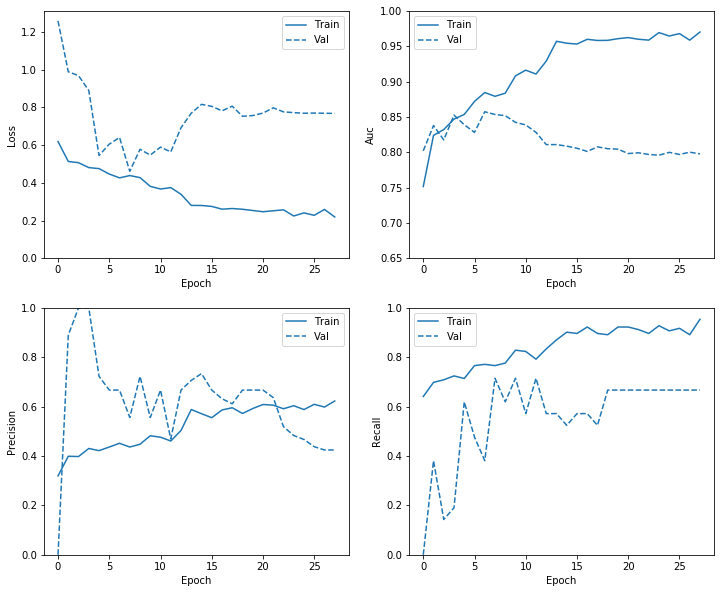

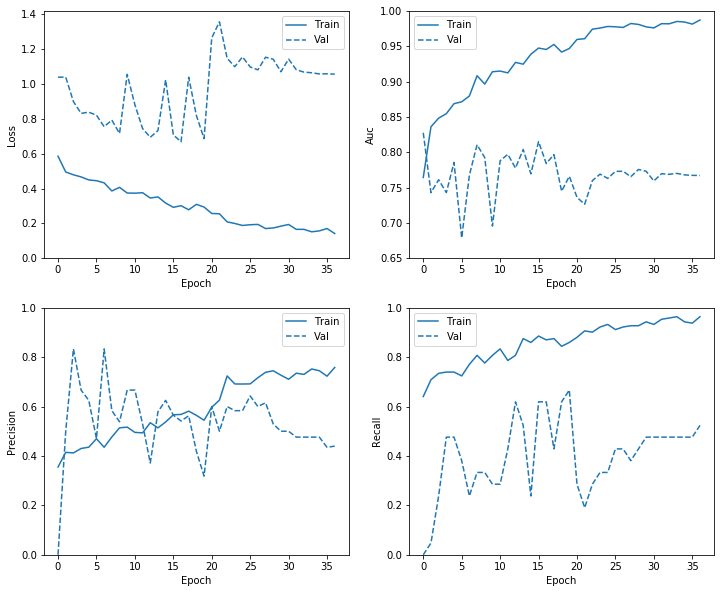

In [57]:
for i, h in enumerate(model_keras_w_history):
    plot_nn_metrics(h)

### 6.2. Oversampling Series

#### 6.2.1. Optimization - Bayesian Optimization on weighted model

In [58]:
def fit_with_smote(
    learn_rate, 
    l1_neurons, 
    l2_neurons, 
    l2_dropout,
    BATCH_SIZE,
    X = X_SMOTE_mm,
    y = y_SMOTE
):
    X = np.array(train_features)
    y = train_labels
    # Split of data for evaluation (random state defined)
    X, X_val, y, y_val = train_test_split(X, y, stratify=y, random_state=0, test_size=0.1)
    # Instatiate model
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(y)
    initial_bias = np.log([pos_nn/neg_nn])
    
    # Discretize parameters
    l1_neurons = max(int(l1_neurons)*2, 32)
    l2_neurons = max(int(l2_neurons)*2, 2)
    BATCH_SIZE = max(int(BATCH_SIZE)*16, 16)
    
    model_keras_opt_smote = make_model(
        metrics = METRICS,
        output_bias = initial_bias,
        learn_rate = 0.001,
        l1_neurons = n_init_neurons,
        l2_neurons = 24,
        input_shape = X.shape[-1:],
        l2_dropout = 0.25
    )
    
    results = model_keras_opt_smote.evaluate(minmax.fit_transform(X_val), y_val, batch_size=BATCH_SIZE, verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_opt_smote.save_weights(initial_weights)
    
    # Trainning of the model on the training features
    model_keras_opt_smote.fit(
        minmax.fit_transform(X),
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks = callback,
        validation_data=(minmax.fit_transform(X_val), y_val),
        verbose=0
    )
    
    # Evaluation of model with validation data
    scores = model_keras_opt_smote.evaluate(
        x=X_val, 
        y=y_val,
        verbose=0
    )
    
    precision = scores[1]
    recall = scores[2]
    tn = scores[5]
    tp = scores[6]
    fn = scores[7]
    fp = scores[8]
    mc_numerator = (tp * tn + fp * fn)
    mc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) + 1e-7
    mc_coef = mc_numerator / mc_denominator
    f1_ = 2 * (precision * recall) / (precision + recall + 1e-7) 
    # The target score to maximize
    return f1_

In [59]:
fit_with_partial_smote = partial(fit_with_smote)

optimizer_smote = BayesianOptimization(
    f=fit_with_partial_smote,
    pbounds=p_bounds,
    verbose=2,
    random_state=0
)

optimizer.probe(
    params={
    'learn_rate':0.1, 
    'l1_neurons':16.0,
    'l2_neurons':13.0,
    'l2_dropout':0.6,
    'BATCH_SIZE':1.0,
    },
    lazy=True
)

optimizer_smote.maximize(
    init_points=20,
    n_iter=n_opt
)

print('learn_rate:', optimizer_smote.max['params']['learn_rate'])
print('l1_neurons:', max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32))
print('l2_neurons:', max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2))
print('l2_dropout:', optimizer_smote.max['params']['l2_dropout'])
print('BATCH_SIZE:', max(int(optimizer_smote.max['params']['BATCH_SIZE'])*16, 16))

|   iter    |  target   | BATCH_... | l1_neu... | l2_dro... | l2_neu... | learn_... |
-------------------------------------------------------------------------------------
|  1        |  0.2727   |  3.14     |  22.44    |  0.3617   |  7.539    |  0.04242  |
|  2        |  0.2727   |  3.519    |  19.94    |  0.5351   |  12.56    |  0.03841  |
|  3        |  0.0      |  4.088    |  20.76    |  0.3408   |  12.11    |  0.007197 |
|  4        |  0.2727   |  1.34     |  16.18    |  0.4996   |  10.34    |  0.08701  |
|  5        |  0.0      |  4.817    |  23.19    |  0.2769   |  10.37    |  0.01192  |
|  6        |  0.2982   |  3.496    |  17.29    |  0.5668   |  7.262    |  0.04152  |
|  7        |  0.2909   |  2.032    |  22.97    |  0.2737   |  7.821    |  0.001977 |
|  8        |  0.0      |  3.409    |  21.51    |  0.3702   |  12.32    |  0.06821  |
|  9        |  0.2727   |  2.402    |  19.93    |  0.4186   |  1.723    |  0.06671  |
|  10       |  0.2832   |  3.615    |  17.89    |  0.0

BEST:

    learn_rate: 0.036434706017168
    l1_neurons: 34
    l2_neurons: 8
    l2_dropout: 0.07735577859291198
    BATCH_SIZE: 48

In [60]:
import datetime
timestamp = datetime.datetime.today().strftime ('%Y%m%d_%H%M')

with open('../logs/nn_opt_log.txt', 'a') as file:
    file.write(str(timestamp) + ','+ 'SMOTE f1, ' + str(optimizer.max) + '\n')
file.close()

In [61]:
learn_rate_smote = optimizer_smote.max['params']['learn_rate']
l1_neurons_smote = max(int(optimizer_smote.max['params']['l1_neurons'])*2, 32)
l2_neurons_smote = max(int(optimizer_smote.max['params']['l2_neurons'])*2, 2)
l2_dropout_smote = optimizer_smote.max['params']['l2_dropout']
BATCH_SIZE_smote = max(int(optimizer_smote.max['params']['BATCH_SIZE'])*16, 16)

tf.keras.backend.clear_session()

We'll select the best hyperparameters as follows:

In [65]:
learn_rate_smote = 0.036434706017168
l1_neurons_smote = 34
l2_neurons_smote = 8
l2_dropout_smote = 0.07735577859291198
BATCH_SIZE_smote = 48

#### 6.2.2. Evaluation - Stratified K-Fold CV

In [62]:
model_keras_smote_history = []
for index, (train_indices, val_indices) in enumerate(skf.split(train_features_v, train_labels)):
    print("Training on fold " + str(index+1) + "/" + str(skf.n_splits) + "...", end='\r')
    # Generate batches from indices
    xtrain, xval = train_features_v[train_indices], train_features_v[val_indices]
    ytrain, yval = train_labels[train_indices], train_labels[val_indices]
    
    # Oversampling training sets
    xtrain_SMOTE, ytrain_SMOTE = smote.fit_sample(xtrain, ytrain)
    xtrain_SMOTE = minmax.fit_transform(xtrain_SMOTE)
    xval = minmax.fit_transform(xval)
    
    # Clear model
    model_keras_smote = None
    
    #Loss with correct initialization and saving of bias onto model
    neg_nn, pos_nn = np.bincount(ytrain_SMOTE)
    initial_bias = np.log([pos_nn/neg_nn])
    
    model_keras_smote = make_model(
        metrics = METRICS,
        output_bias= initial_bias,
        learn_rate= learn_rate_smote,
        l1_neurons= l1_neurons_smote,
        l2_neurons= l2_neurons_smote,
        input_shape = X.shape[-1:],
        l2_dropout= l2_dropout_smote
    )
    
    results = model_keras_smote.evaluate(
        xtrain, 
        ytrain, 
        batch_size=BATCH_SIZE_smote, 
        verbose=0)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model_keras_smote.save_weights(initial_weights)

    baseline_history_smote = model_keras_smote.fit(
        xtrain_SMOTE,
        ytrain_SMOTE,
        batch_size=BATCH_SIZE_smote,
        epochs=EPOCHS,
        callbacks = callback,
        validation_data=(xval, yval),
        verbose=0)

    model_keras_smote_history.append(baseline_history_smote)
    m_summary = save_metrics(
        m_summary, 'NN_weighted', ytrain_SMOTE, model_keras_smote.predict_classes(xtrain_SMOTE), model_keras_smote.predict_proba(xtrain_SMOTE),
        batch_size=BATCH_SIZE_smote, split_data='train', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'NN_weighted', yval, model_keras_smote.predict_classes(xval), model_keras_smote.predict_proba(xval),
        batch_size=BATCH_SIZE_smote, split_data='val', series='SMOTE')
    m_summary = save_metrics(
        m_summary, 'NN_weighted', test_labels, model_keras_smote.predict_classes(test_features), model_keras_smote.predict_proba(test_features),
        batch_size=BATCH_SIZE_smote, split_data='test', series='SMOTE')
print(' ...Done')

 ...Done on fold 10/10...


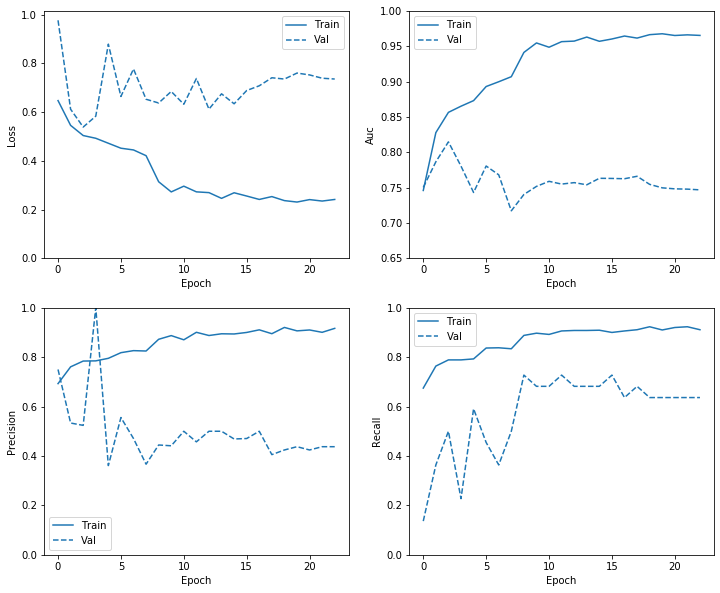

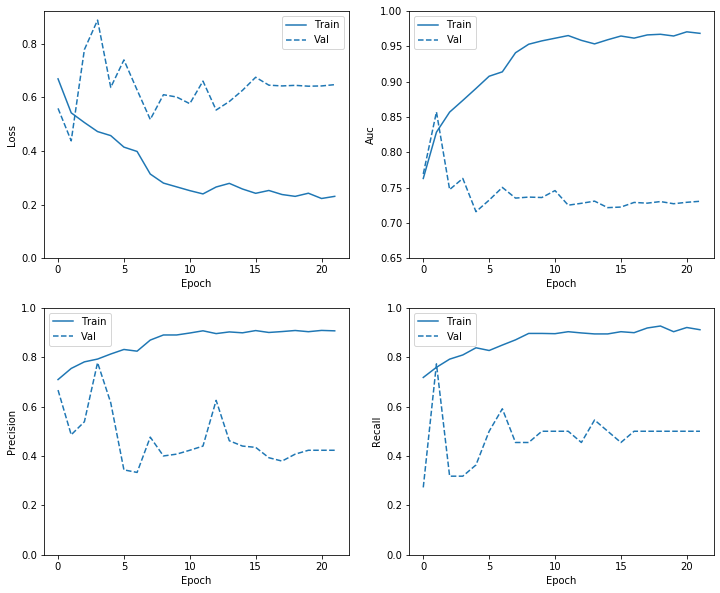

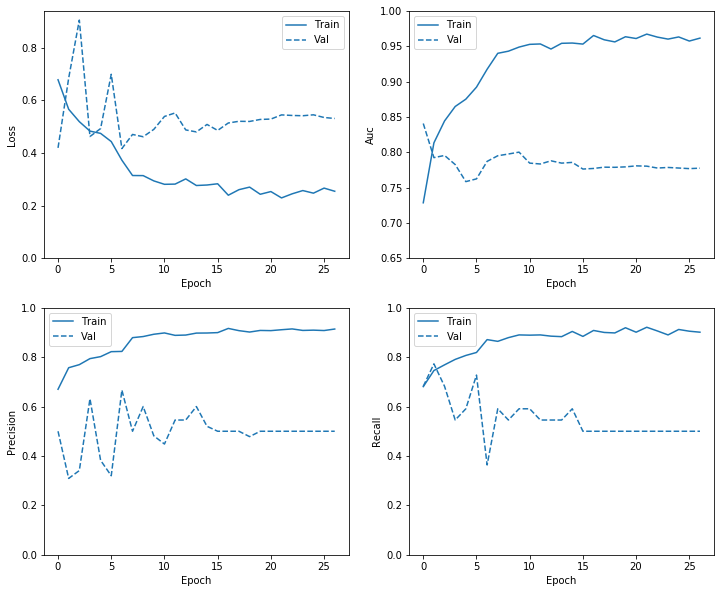

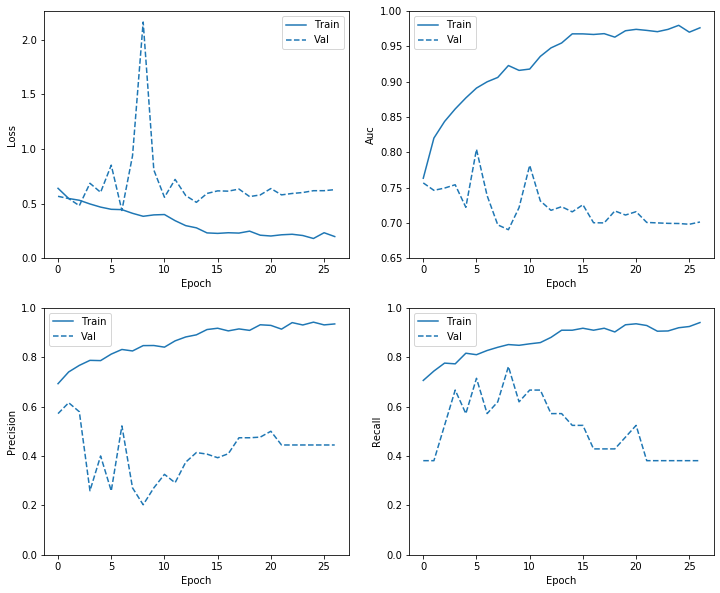

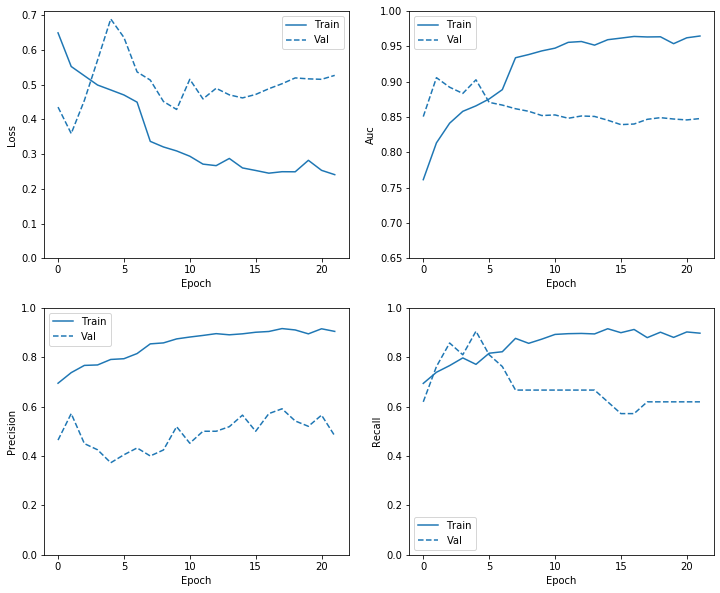

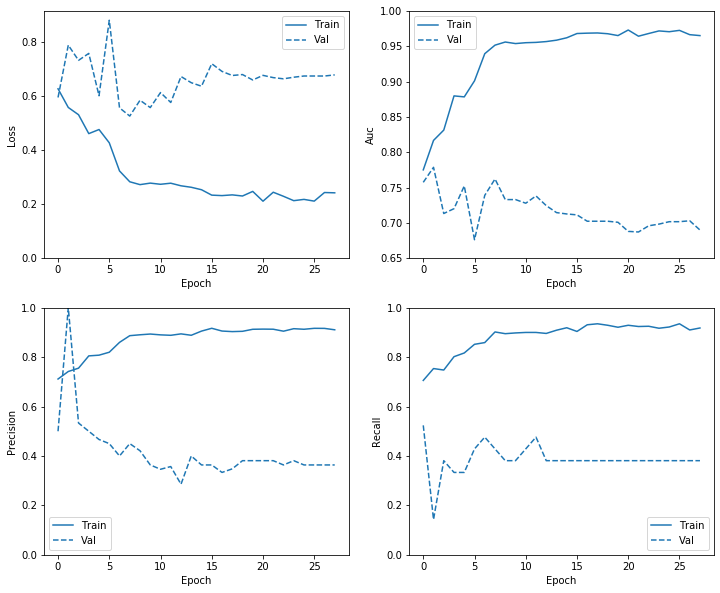

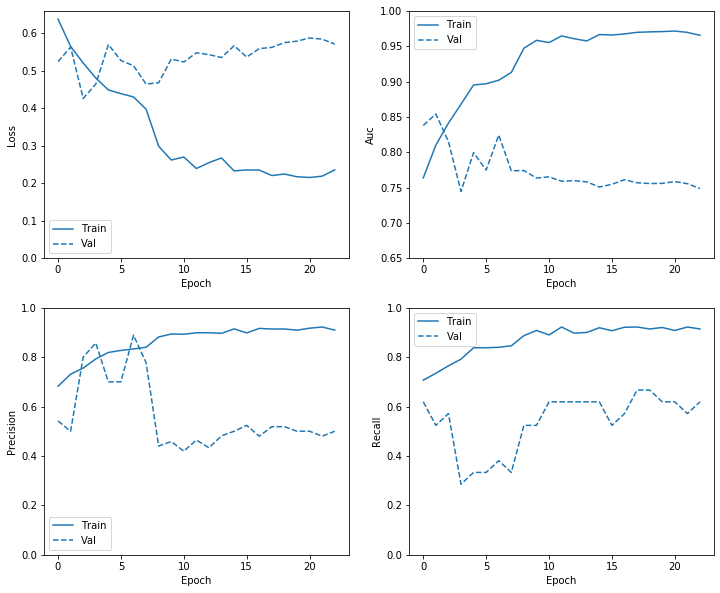

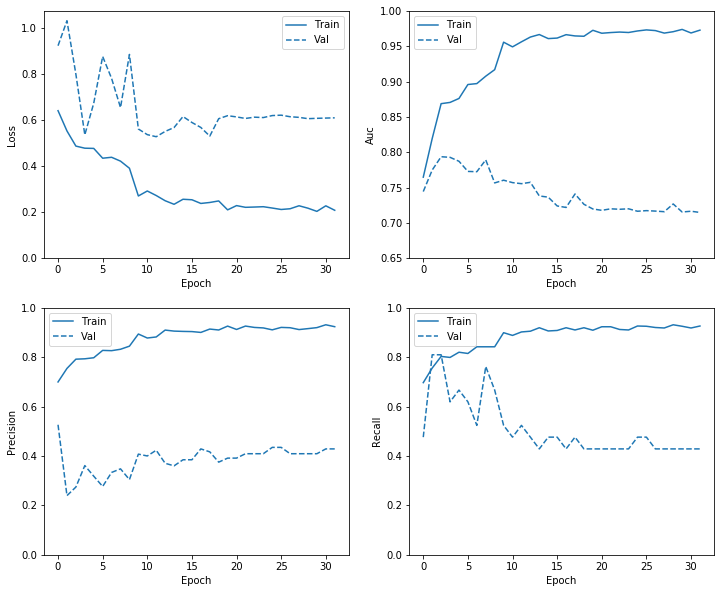

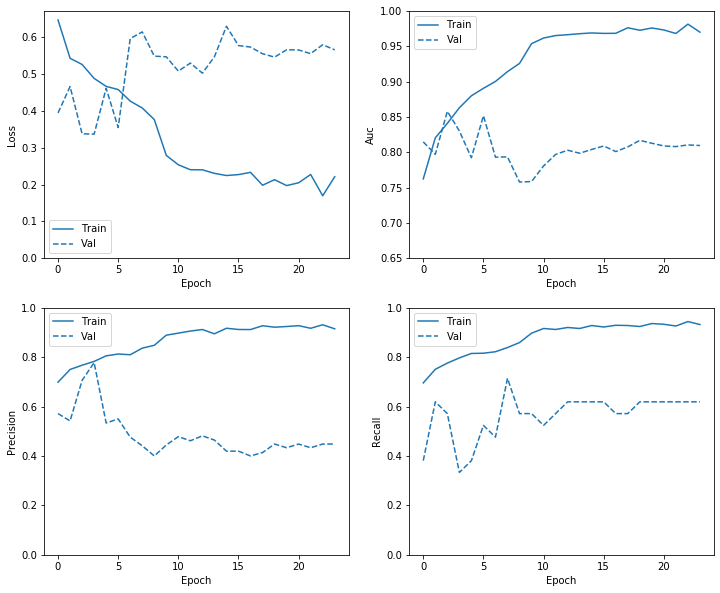

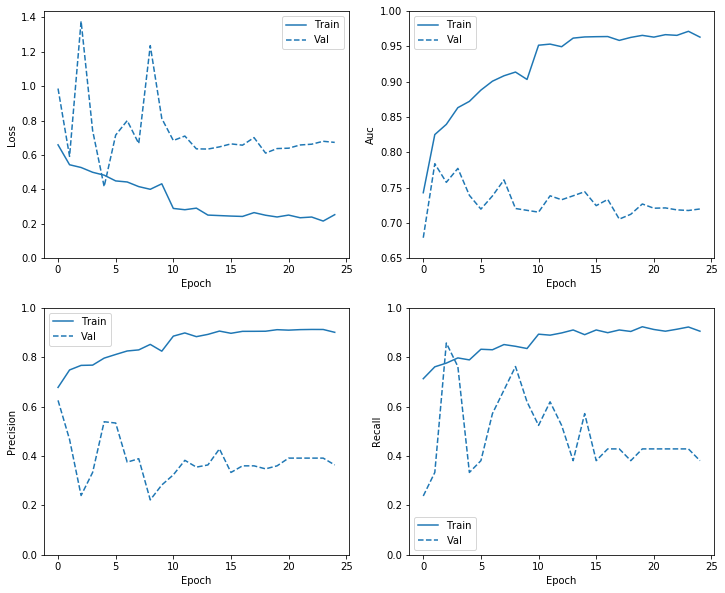

In [63]:
for i, h in enumerate(model_keras_smote_history):
    plot_nn_metrics(h)

In [64]:
tf.keras.backend.clear_session()

# III. Selecting Best Models

The selection of the best model(s) is based on the following ordered metrics:
1. The Matthews correlation coeficient;
    * Measures of the quality of binary (two-class) classifications
    * Takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes.
    * In essence a correlation coefficient between the observed and predicted binary classifications
2. Recall;
    * Probability of finding a True positive taking into account False negatives (Tipe II error)
    * In our case, we better have a model that identifies all attrition (True positives) instead of being only accurate in True negatives
3. Precision vs Recall AUC.
    * The Area under the curve of Precision vs Recall curve do not consider true negatives
    * Used when precision is of no concern for the classifier, which is the case.

Bellow we have the pr curves for the test data (although we haven't trainned yet the selected model(s) on the full training
subset

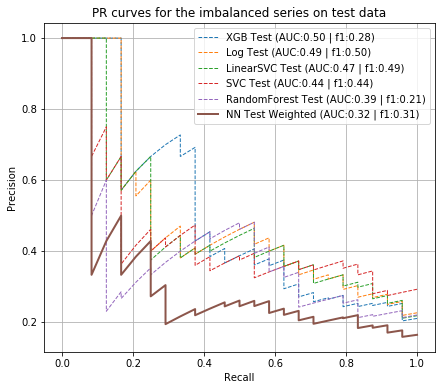

In [66]:
plt.figure(figsize=(7, 7))
plot_pr_curve(
    "XGB Test", test_labels, model_XGB.predict_proba(test_features)[:, 1], model_XGB.predict(test_features),
    lcolor=colors[0], lstyle='--', lwidth=1)
plot_pr_curve(
    "Log Test", test_labels, model_logistic.predict_proba(test_features)[:, 1], model_logistic.predict(test_features),
    lcolor=colors[1], lstyle='--', lwidth=1)
plot_pr_curve(
    "LinearSVC Test", test_labels, model_LinearSVC.decision_function(test_features), model_LinearSVC.predict(test_features),
    lcolor=colors[2], lstyle='--', lwidth=1)
plot_pr_curve(
    "SVC Test", test_labels, model_SVC.predict_proba(test_features)[:, 1], model_SVC.predict(test_features),
    lcolor=colors[3], lstyle='--', lwidth=1)
plot_pr_curve(
    "RandomForest Test", test_labels, model_RandomForest.predict_proba(test_features)[:, 1], model_RandomForest.predict(test_features),
    lcolor=colors[4], lstyle='--', lwidth=1)
plot_pr_curve(
    "NN Test Weighted", test_labels, model_keras_w.predict_proba(test_features), model_keras_w.predict_classes(test_features, batch_size=BATCH_SIZE),
    lcolor=colors[5], lstyle='-')
plt.title('PR curves for the imbalanced series on test data')
plt.legend(loc='upper right')
plt.show()

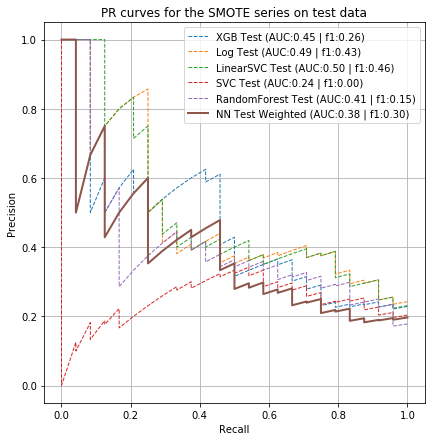

In [67]:
plt.figure(figsize=(7, 7))
plot_pr_curve(
    "XGB Test", test_labels, model_XGB_smote.predict_proba(test_features)[:, 1], model_XGB_smote.predict(test_features),
    lcolor=colors[0], lstyle='--', lwidth=1)
plot_pr_curve(
    "Log Test", test_labels, model_logistic_smote.predict_proba(test_features)[:, 1], model_logistic_smote.predict(test_features),
    lcolor=colors[1], lstyle='--', lwidth=1)
plot_pr_curve(
    "LinearSVC Test", test_labels, model_LinearSVC_smote.decision_function(test_features), model_LinearSVC_smote.predict(test_features),
    lcolor=colors[2], lstyle='--', lwidth=1)
plot_pr_curve(
    "SVC Test", test_labels, model_SVC_smote.predict_proba(test_features)[:, 1], model_SVC_smote.predict(test_features),
    lcolor=colors[3], lstyle='--', lwidth=1)
plot_pr_curve(
    "RandomForest Test", test_labels, model_RandomForest_smote.predict_proba(test_features)[:, 1], model_RandomForest_smote.predict(test_features),
    lcolor=colors[4], lstyle='--', lwidth=1)
plot_pr_curve(
    "NN Test Weighted", test_labels, model_keras_smote.predict_proba(test_features), model_keras_smote.predict_classes(test_features, batch_size=BATCH_SIZE),
    lcolor=colors[5], lstyle='-')
plt.title('PR curves for the SMOTE series on test data')
plt.legend(loc='upper right')
plt.show()

In [68]:
m_summary[['tp', 'fp', 'tn', 'fn']] = m_summary[['tp', 'fp', 'tn', 'fn']].astype(int)

And now we rank the models based on the previous assumptions: we want the best models by 'mc_coef', then 'recall' and finnaly 'pr_auc'

In [69]:
m_summary.groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall', 'pr_auc'], ascending=False).applymap(lambda x: np.round(x,2))

,,,tp,fp,tn,fn,bal_acc,prec,recall,pr_auc,f1,mc_coef,batch_s
model,data,series,,,,,,,,,,,
model_SVC,train,SMOTE,999.0,0.0,999.0,0.0,1.00,1.00,1.00,1.00,1.00,1.00,NaN
model_XGB,train,SMOTE,996.8,0.0,999.0,2.2,1.00,1.00,1.00,1.00,1.00,1.00,NaN
model_RandomForest,train,SMOTE,986.8,0.0,999.0,12.2,0.99,1.00,0.99,1.00,0.99,0.99,NaN
model_XGB,train,imbalanced,171.3,0.0,999.0,20.4,0.95,1.00,0.89,1.00,0.94,0.94,NaN
model_RandomForest,train,imbalanced,157.5,35.0,964.0,34.2,0.89,0.82,0.82,0.90,0.82,0.79,NaN
NN_weighted,train,SMOTE,697.1,71.1,927.9,301.9,0.81,0.91,0.70,0.93,0.77,0.65,16.0
model_LinearSVC,train,SMOTE,830.6,224.9,774.1,168.4,0.80,0.79,0.83,0.88,0.81,0.61,NaN
model_logistic,train,SMOTE,827.8,234.9,764.1,171.2,0.80,0.78,0.83,0.87,0.80,0.59,NaN
model_SVC,train,imbalanced,166.3,152.5,846.5,25.4,0.86,0.52,0.87,0.78,0.65,0.59,NaN


In [190]:
m_val_summary = m_summary[m_summary['data'] == 'val'].groupby(['model', 'data', 'series']).mean().sort_values(by=['mc_coef', 'recall', 'pr_auc'], ascending=False).applymap(lambda x: np.round(x,4))
m_val_summary

tp    fp     tn    fn  bal_acc    prec  \
model              data series                                                 
NN_weighted        val  imbalanced  12.2   6.8  104.2   8.8   0.7598  0.6508   
                        SMOTE       11.0   9.2  101.8  10.3   0.7166  0.5759   
model_logistic     val  SMOTE       16.5  23.4   87.6   4.8   0.7815  0.4141   
model_LinearSVC    val  SMOTE       15.0  21.4   89.6   6.3   0.7556  0.4153   
model_RandomForest val  imbalanced   9.7   8.3  102.7  11.6   0.6906  0.5436   
model_SVC          val  imbalanced  14.6  21.4   89.6   6.7   0.7465  0.4067   
model_RandomForest val  SMOTE        5.5   1.7  109.3  15.8   0.6215  0.7631   
model_logistic     val  imbalanced  15.6  26.6   84.4   5.7   0.7462  0.3692   
model_LinearSVC    val  imbalanced  15.4  26.5   84.5   5.9   0.7421  0.3674   
model_XGB          val  imbalanced   5.7   2.2  108.8  15.6   0.6236  0.7169   
model_SVC          val  SMOTE        0.9   0.7  110.3  20.4   0.5180  0.3667   
model_XGB          val  SMOTE        0.0   0.0  111.0  21.3   0.5000  0.0000   

                                    recall  pr_auc      f1  mc_coef  batch_s  
model              data series                                                
NN_weighted        val  imbalanced  0.5810  0.6897  0.5991   0.5413     48.0  
                        SMOTE       0.5160  0.5717  0.5229   0.4519     16.0  
model_logistic     val  SMOTE       0.7738  0.6339  0.5385   0.4516      NaN  
model_LinearSVC    val  SMOTE       0.7039  0.5813  0.5189   0.4226      NaN  
model_RandomForest val  imbalanced  0.4561  0.5467  0.4924   0.4097      NaN  
model_SVC          val  imbalanced  0.6857  0.5657  0.5098   0.4076      NaN  
model_RandomForest val  SMOTE       0.2582  0.5861  0.3820   0.3910      NaN  
model_logistic     val  imbalanced  0.7320  0.5895  0.4902   0.3883      NaN  
model_LinearSVC    val  imbalanced  0.7229  0.5820  0.4862   0.3827      NaN  
model_XGB          val  imbalanced  0.2671  0.5333  0.3854   0.3804      NaN  
model_SVC          val  SMOTE       0.0422  0.3339  0.0751   0.0958      NaN  
model_XGB          val  SMOTE       0.0000  0.4051  0.0000   0.0000      NaN

In [71]:
m_val_summary.head(3)

tp    fp     tn    fn  bal_acc  prec  \
model          data series                                               
NN_weighted    val  imbalanced  12.2   6.8  104.2   8.8     0.76  0.65   
                    SMOTE       11.0   9.2  101.8  10.3     0.72  0.58   
model_logistic val  SMOTE       16.5  23.4   87.6   4.8     0.78  0.41   

                                recall  pr_auc    f1  mc_coef  batch_s  
model          data series                                              
NN_weighted    val  imbalanced    0.58    0.69  0.60     0.54     48.0  
                    SMOTE         0.52    0.57  0.52     0.45     16.0  
model_logistic val  SMOTE         0.77    0.63  0.54     0.45      NaN

It's clear that the top 3 are the Neural Network in both series, and the SMOTE'd logistic model

In [72]:
m_summary.to_csv('../logs/metrics_summary.csv')
m_val_summary.to_csv('../logs/metrics_validation_summary.csv')

## A. Model saving

In [73]:
import pickle

Enable the code block if saving the models are required

## B. Model metrics plotting

Now we transform the summary performace dataframe into to a tidy format to further view the metrics for the models tested.

In [74]:
m_summary_melted = pd.melt(
    m_summary, 
    id_vars=['model', 'data', 'series'], 
    value_vars=[
        'tp', 'fp', 'tn', 'fn', 
        'bal_acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef'
    ], 
    var_name='metrics', 
    value_name='values')

m_summary_melted.to_csv('../logs/metrics_summary_melted.csv')

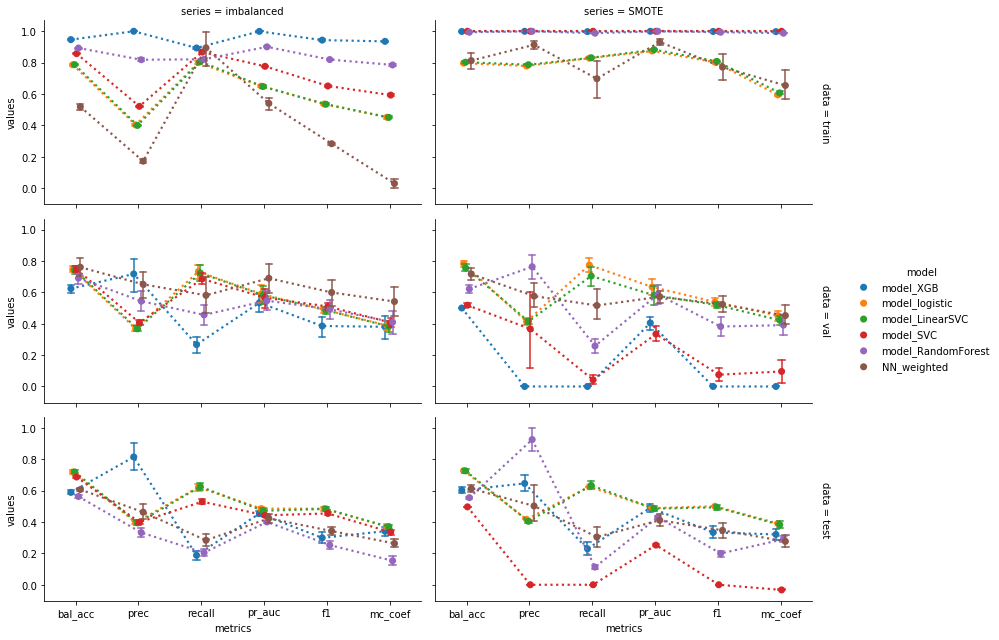

In [75]:
sb.catplot(
    y='values',
    x='metrics',
    hue='model',
    data=m_summary_melted[m_summary_melted.metrics.isin(['bal_acc', 'prec', 'recall', 'pr_auc', 'f1', 'mc_coef'])], 
    col='series', 
    row='data',
    estimator= np.mean,
    ci=95, 
    n_boot=1000, 
    kind='point', 
    height=3,
    aspect=2, 
    palette='tab10', 
    legend=True, 
    legend_out=True, 
    sharex=True, 
    sharey=True, 
    margin_titles=True, 
    **{
        'linestyles':':',
        'scale':0.8,
        'dodge':True,
        'capsize':0.1,
        'errwidth':1.5
    }
)
plt.show()

We can see that the top 2 models are the Keras DNN on the imbalanced dataset and the sklearn logistic regression on the SMOTE dataset, but not by a huge margin.

The Neural Network performs well in a non artifical dataset (not SMOTED). On the other hand the logistic model is the best when facing the SMOTE'd dataset.

## C. Feature importance (permutation)

Let's check the importance of features by permutation to find the relevant features in both the logistic model and the Keras NN model

Firstly, the logistic model on SMOTE

In [80]:
from mlxtend.evaluate import feature_importance_permutation

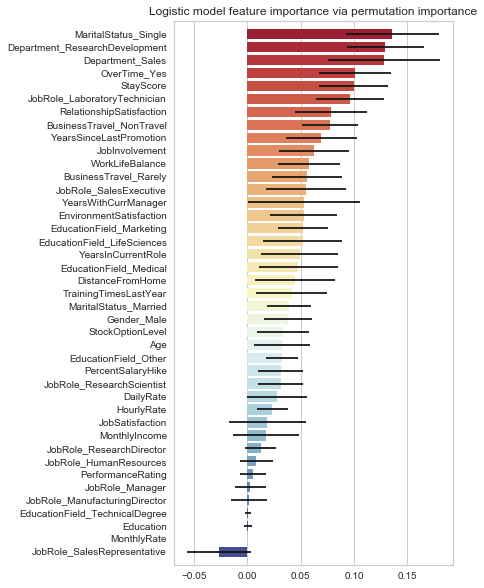

In [81]:
x_smote, y_smote = smote.fit_sample(train_features, train_labels)
x_smote = minmax.fit_transform(x_smote)

model_logistic_smote.fit(x_smote, y_smote)

imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_logistic_smote.predict, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=50,
    seed=1)

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()
#imp_all = minmax.fit_transform(imp_all)

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("Logistic model feature importance via permutation importance")
sb.barplot(y=test_df.drop('Attrition_Yes', axis=1).columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
plt.ylim([-1, test_df.drop('Attrition_Yes', axis=1).shape[1]])
plt.show()

And now the Keras NN model:

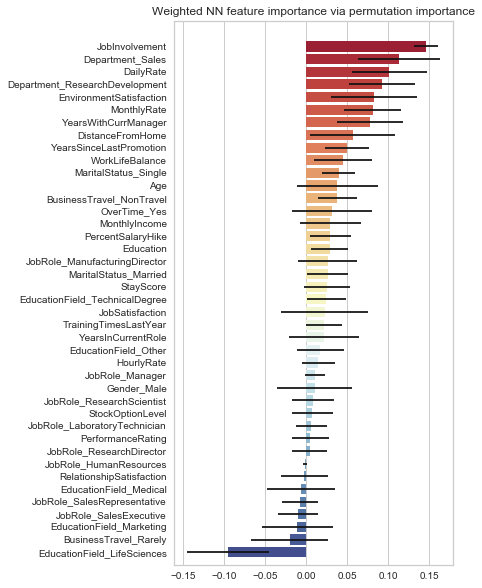

In [294]:
imp_vals, imp_all = feature_importance_permutation(
    predict_method=model_keras_w.predict_classes, 
    X=test_features,
    y=test_labels,
    metric=metrics.f1_score,
    num_rounds=50,
    seed=1)

X=test_df
y=test_labels

#imp_vals = minmax.fit_transform(imp_vals.reshape(-1,1)).ravel()

std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::1]

plt.figure(figsize=(5,10))
plt.title("Weighted NN feature importance via permutation importance")
sb.barplot(y=test_df.drop('Attrition_Yes', axis=1).columns[indices], x=imp_vals[indices], xerr=std[indices], palette="RdYlBu_r")
plt.ylim([-1, X.shape[1]])
plt.show()

# IV. Trial on the Out of Sample Dataset

As we said before, now is the time to test the models on the remaining 10% data from the original dataset. The objective here is to simulate the trainning/validation, then selecting the best model(s) and finnaly, access to new real data so we can trully test the models as a true Out of Sample testing. So to simplify things, this is what will happen:
1. Train models on the full Train dataset
2. Predict on test dataset (features) and add the result to the Test dataset
3. Add the previously found OPTICS clusters on the results
    * Test features (without min max) + prediction of models (Yes, No) + Cluster

In order to cut short on the rest of the notebook, the following hyperparameters were found to be best for the Keras Deep Neural Network (IMBALANCED Dataset):

    learn_rate: 0.0005690780716354519
    l1_neurons: 46
    l2_neurons: 20
    l2_dropout: 0.012064527712496132
    BATCH_SIZE: 32
    
    learn_rate: 0.011960899123528981
    l1_neurons: 36
    l2_neurons: 8
    l2_dropout: 0.07211793672790134
    BATCH_SIZE: 16
    
    learn_rate: 0.036434706017168
    l1_neurons: 34
    l2_neurons: 8
    l2_dropout: 0.07735577859291198
    BATCH_SIZE: 48

## 1. Train Keras DNN & predict on the test subdataset

In [191]:
model_keras_wfinal = None

X = train_features_norm
y = train_labels

#Loss with correct initialization and saving of bias onto model
neg_nn, pos_nn = np.bincount(y)
initial_bias = np.log([pos_nn/neg_nn])

model_keras_wfinal = make_model(
    metrics = METRICS,
    output_bias = initial_bias,
    learn_rate = 0.0006,
    l1_neurons = 46,
    l2_neurons = 20,
    input_shape = X.shape[-1:],
    l2_dropout = 0.2
)

results = model_keras_wfinal.evaluate(xtrain, ytrain, batch_size=16, verbose=0)
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model_keras_wfinal.save_weights(initial_weights)

baseline_history_final = model_keras_wfinal.fit(
    X,
    y,
    batch_size=16,
    epochs=EPOCHS,
    callbacks = callback,
    validation_split=0.1,
    shuffle=True,
    use_multiprocessing=True,
    class_weight=class_weights,
    verbose=0)

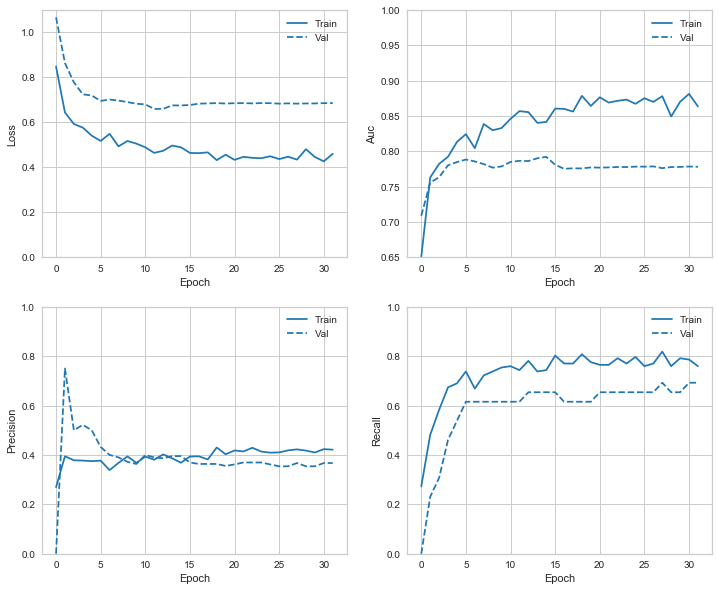

In [192]:
plot_nn_metrics(baseline_history_final)

## 2. Train Logistic Model & predict on the test subdataset

In [193]:
X_smote, y_smote = smote.fit_sample(train_features, train_labels)

In [194]:
model_logistic_smotefinal = model_logistic_smote
model_logistic_smotefinal.fit(X_smote, y_smote)

LogisticRegression(C=10, class_weight={0: 1, 1: 1}, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=-1, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=0,
                   warm_start=True)

## 3. Fact & performance checking on predicted dataset
Now we will do a simple performance check on both trained models 

In [195]:
y_predict_final_KDNN = model_keras_wfinal.predict_classes(test_features).ravel()

In [196]:
y_predict_final_LRS = model_logistic_smotefinal.predict(test_features).ravel()

Matthews correlation coeficient on the Keras DNN, and the classification report

In [197]:
metrics.matthews_corrcoef(test_labels, y_predict_final_KDNN)

0.4681198165571423

In [199]:
print(metrics.classification_report(test_labels, y_predict_final_KDNN))

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       123
           1       0.48      0.67      0.56        24

    accuracy                           0.83       147
   macro avg       0.71      0.76      0.73       147
weighted avg       0.86      0.83      0.84       147



Matthews correlation coeficient on the Logistic model, and the classification report

In [198]:
metrics.matthews_corrcoef(test_labels, y_predict_final_LRS)

0.4613332095203845

In [200]:
print(metrics.classification_report(test_labels, y_predict_final_LRS))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       123
           1       0.50      0.62      0.56        24

    accuracy                           0.84       147
   macro avg       0.71      0.75      0.73       147
weighted avg       0.85      0.84      0.84       147



Finnaly we'll check the resulting Out of sample dataframe (test sub dataset)

In [201]:
OutOS_df = test_df.copy()

OutOS_df['Attrition_KDNN'] = y_predict_final_KDNN
OutOS_df['Attrition_LRS'] = y_predict_final_LRS
OutOS_df['ClusterOptics'] = finaldf_clusters['optics_cluster'].loc[test_df.index]

In [202]:
OutOS_df[['Attrition_KDNN', 'Attrition_LRS', 'Attrition_Yes', 'ClusterOptics']].groupby(['Attrition_Yes', 'ClusterOptics']).median()

Attrition_KDNN  Attrition_LRS
Attrition_Yes ClusterOptics                               
0             -1                          0              0
               1                          0              0
               2                          0              0
               4                          0              0
               8                          0              0
               9                          0              0
1             -1                          1              1
               0                          1              1
               14                         1              1

Both models performed well in either the attrition prediction and the clusters as well (for majority of the distribution)

In [203]:
OutOS_df[['Attrition_KDNN', 'Attrition_LRS', 'Attrition_Yes', 'ClusterOptics']].groupby(['Attrition_Yes', 'ClusterOptics']).count()

Attrition_KDNN  Attrition_LRS
Attrition_Yes ClusterOptics                               
0             -1                        118            118
               1                          1              1
               2                          1              1
               4                          1              1
               8                          1              1
               9                          1              1
1             -1                         21             21
               0                          1              1
               14                         2              2

In [205]:
OutOS_df[OutOS_df['Attrition_KDNN'] == 1].sample(10)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,StayScore,Attrition_Yes,BusinessTravel_NonTravel,BusinessTravel_Rarely,Department_ResearchDevelopment,Department_Sales,EducationField_LifeSciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_TechnicalDegree,Gender_Male,JobRole_HumanResources,JobRole_LaboratoryTechnician,JobRole_Manager,JobRole_ManufacturingDirector,JobRole_ResearchDirector,JobRole_ResearchScientist,JobRole_SalesExecutive,JobRole_SalesRepresentative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,Attrition_KDNN,Attrition_LRS,ClusterOptics
1165,44,602,1,5,1,37,3,4,5743,10503,11,3,3,0,3,3,7,0,2,0.800000,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,1,-1
1095,33,589,28,4,2,79,3,3,5207,22949,12,3,2,1,3,3,14,5,7,0.000000,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,1,-1
525,24,693,3,2,1,65,3,3,4577,24785,14,3,1,0,3,3,2,2,0,0.200000,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,-1
122,56,441,14,4,2,72,3,2,4963,4510,18,3,1,3,2,3,4,4,3,0.200000,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,-1
1102,36,1157,2,4,3,70,3,4,2644,17001,21,4,4,0,3,2,2,1,2,1.000000,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,1,1,-1
149,19,1181,3,1,2,79,3,2,1483,16102,14,3,4,0,3,3,0,0,0,0.000000,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,-1
1428,32,234,1,4,2,68,2,2,2269,18024,14,3,2,1,2,3,2,2,2,1.000000,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,-1
849,43,1372,9,3,1,85,1,3,5346,9489,13,3,2,0,2,2,3,1,3,0.333333,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0
831,31,874,15,3,3,72,3,3,2610,6233,12,3,3,1,5,2,2,2,2,0.000000,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,1,-1
124,31,249,6,4,2,76,1,3,6172,20739,18,3,2,0,3,2,7,7,7,1.000000,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,1,-1


## 4. Feature manipulation - Avoid attrition
Now that we have 2 models that can predict attrition with a plausible degree of freedom, we will manipulate some features (those we can manipulate and also the ones identified with the feature importance analysis done before)

The test is simple:
* Raise the income by 10%
* Enforce a no overtime policy
* Promote employees
* Enforce a Work-Life Balance improver (workshops, family measures, etc)

In [206]:
OutOS_df.to_csv('../logs/out_of_sample_test.csv')

In [290]:
OutOS_df_salary10pc = OutOS_df.copy()
OutOS_df_salary10pc['MonthlyIncome'] *= 1.10
OutOS_df_salary10pc['OverTime_Yes'] = 0
OutOS_df_salary10pc['PercentSalaryHike'] += 10
OutOS_df_salary10pc['YearsSinceLastPromotion'] = 0
OutOS_df_salary10pc['HourlyRate'] *= 1.10
OutOS_df_salary10pc['DailyRate'] *= 1.10
OutOS_df_salary10pc['MonthlyRate'] *= 1.10
OutOS_df_salary10pc['WorkLifeBalance'] += 1

The original attrition:

In [291]:
OutOS_df_salary10pc.Attrition_Yes.sum()

24

The percentage decrease in attrition predicted by Keras DNN with the above improvements:

In [292]:
100 - model_keras_wfinal.predict_classes(
    minmax.fit_transform(
        np.array(
            OutOS_df_salary10pc.drop(
                ['Attrition_KDNN', 'Attrition_LRS', 'ClusterOptics', 'Attrition_Yes'],
                axis=1
            )
        )
    ),
    batch_size=BATCH_SIZE
).ravel().sum()/OutOS_df_salary10pc.Attrition_KDNN.sum()*100

42.42424242424242

The percentage decrease in attrition predicted by Logistic Model with the above improvements:

In [293]:
100 - model_logistic_smotefinal.predict(
    minmax.fit_transform(
        np.array(
            OutOS_df_salary10pc.drop(
                ['Attrition_KDNN', 'Attrition_LRS', 'ClusterOptics', 'Attrition_Yes'],
                axis=1
            )
        )
    )
).ravel().sum()/OutOS_df_salary10pc.Attrition_LRS.sum()*100

46.666666666666664